# Reproducing Adam CDA Study (2018) - Exp1
### Notes

In [3]:
import numpy as np
import glob
import pickle
import pandas as pd
import copy
import scipy

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_eeglab

import os
import sys
#sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/')
sys.path.append('D:\\PhD\\CDA-review\\studies\\')
from cda_utils import get_epochs, get_CDA, prep_report, fill_report, get_report, checksum, add_cda_report, get_CDA_perf_report
#sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Adam-2018/')
sys.path.append('D:\\PhD\\CDA-review\\studies\\Adam-2018')
from events import get_specific_events, convert_triggers
 
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load, Prep & CDA

In [4]:
#==================================================================
# General Variables
#==================================================================
study_id = 'Adam2018-Exp1'

# Organize Triggers
triggers = dict();

# --------------------------
# Fuck-up with events when loading in Python. I don't know why... NEED TO CONVERT.
triggers['1'] = [31, 41]
triggers['3'] = [33, 43]
triggers['6'] = [36, 46]

triggers['left'] = [31, 33, 36]
triggers['right'] = [41, 43, 46]

triggers['good'] = [81,82,83,84,85,86]
triggers['bad'] = [80]

triggers['acc_0'] = [80]
triggers['acc_1'] = [81]
triggers['acc_2'] = [82]
triggers['acc_3'] = [83]
triggers['acc_4'] = [84]
triggers['acc_5'] = [85]
triggers['acc_6'] = [86]
    
# Labels
conds = ['1', '3', '6']
sides = ['left', 'right']
perfs = ['good', 'bad'] # Here it is slightly different! (because of granular accuracies!)
accs =  ['acc_0', 'acc_1', 'acc_2', 'acc_3', 'acc_4', 'acc_5', 'acc_6']

# Internal Triggers to Epochs Properly
internal_triggers = dict()
internal_triggers_count = 0
for cond in conds:
    for side in sides:
        for perf in accs: #perfs:
            internal_triggers_count = internal_triggers_count + 1
            internal_triggers['{}-{}-{}'.format(cond,side,perf)] = internal_triggers_count
            
# CDA Channels
chan_right = ['O2', 'P4', 'PO4', 'T6'] # Not using: 'OR' because of cleaning... (no position set for OR)
chan_left =  ['O1', 'P3', 'PO3', 'T5'] # Not using: 'OL' because of cleaning... (no position set for OL)

# Channels
chanLabels = {'EEG 000':'PO3', 'EEG 001':'PO4', 'EEG 002':'F3', 'EEG 003':'F4', 'EEG 004':'C3', 'EEG 005':'C4', 'EEG 006':'P3', 'EEG 007':'P4', 'EEG 008':'O1', 'EEG 009':'O2', 'EEG 010':'OL', 'EEG 011':'OR', 'EEG 012':'T3', 'EEG 013':'T4', 'EEG 014':'T5', 'EEG 015':'T6', 'EEG 016':'POz', 'EEG 017':'Cz', 'EEG 018':'Fz', 'EEG 019':'Pz', 'EEG 020':'VEOG', 'EEG 021':'HEOG'}

# Epoc Information
epoch_length = 1.5  #1.65
epoch_tmin = -0.2
baseline_corr = (-0.2, 0)

# CDA info
cda_window = (0.4, 1.5)

# CDA main variable!
cda_dict_all = dict()
epochs_dict_all = dict()
perf_report_all = dict()
report = prep_report(conds, sides, accs) #perfs)

times = None


In [2]:
#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
directory_path = '/Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/'

eegfiles = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(directory_path)
    for f in files if f.endswith('.set')]

#filepath = directory_path + '1_DWR_Bilateral.set'
for filepath in eegfiles:
    filename = filepath[filepath.rfind('/')+1:]
    print('Processing: ' + filename + '...')

    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_eeglab(filepath, preload=True)

    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    # Set Electrodes Locations - Used Brain Products (locations seem to in eeg file...)
    raw.rename_channels(chanLabels);
    raw.set_channel_types({'VEOG':'eog', 'HEOG':'eog', 'OR':'misc', 'OL':'misc'})
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='warn')

    preproc = raw

    # Filter
    preproc = preproc.filter(.1, 20., fir_design='firwin', skip_by_annotation='edge')

    # Events
    events = mne.events_from_annotations(preproc)

    # Select Channels (to save time on cleaning)
    #preproc = preproc.pick_channels(chan_right + chan_left)

    # Plot (visual check)
    #preproc.plot(events=events, block=True, lowpass=40)

    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    new_triggers = copy.deepcopy(triggers)
    new_triggers = convert_triggers(events, conds, sides, perfs, accs, new_triggers)

    specific_events = get_specific_events(events[0], conds, sides, perfs, accs, new_triggers, internal_triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr, clean=True)

    epochs_dict_all[filename] = epochs_dict

    # times, used for CDA mean amp report.
    if times is None: times = epochs_dict[conds[0]][sides[0]][accs[0]].times 

    # ------------------------
    # 4. -- CDA --
    # ------------------------
    cda_dict_all[filename] = get_CDA(epochs_dict, conds, sides, accs, chan_right, chan_left)

    # ------------------------
    # 6. - Report & Checksum -
    # ------------------------
    report = fill_report(report, filename, specific_events)
    report = add_cda_report(report, filename, conds, sides, accs, cda_dict_all[filename], times, cda_window=cda_window)
    report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)

    perf_report_all[filename] = get_CDA_perf_report(epochs_dict, conds, sides, accs, chan_right, chan_left, cda_window=cda_window)

# Print report
print('{} Subjects & {} Trials'.format(len(report), 2*np.sum([report[cond].sum() for cond in conds])))
report

NameError: name 'os' is not defined

## 2. Plot Grand CDA Average

==== SKIPPED: 0 points! (File: 3_DWR_Bilateral.set - Cond: 3 - Acc: acc_1)
==== SKIPPED: 0 points! (File: 3_DWR_Bilateral.set - Cond: 6 - Acc: acc_1)
==== SKIPPED: 0 points! (File: 14_DWR_Bilateral.set - Cond: 6 - Acc: acc_5)
==== SKIPPED: 0 points! (File: 15_DWR_Bilateral.set - Cond: 6 - Acc: acc_5)
==== SKIPPED: 0 points! (File: 22_DWR_Bilateral.set - Cond: 6 - Acc: acc_5)
==== SKIPPED: 0 points! (File: 23_DWR_Bilateral.set - Cond: 6 - Acc: acc_5)
==== SKIPPED: 0 points! (File: 24_DWR_Bilateral.set - Cond: 6 - Acc: acc_5)
==== SKIPPED: 0 points! (File: 26_DWR_Bilateral.set - Cond: 6 - Acc: acc_5)
==== SKIPPED: 0 points! (File: 28_DWR_Bilateral.set - Cond: 6 - Acc: acc_5)
==== SKIPPED: 0 points! (File: 10_DWR_Bilateral.set - Cond: 6 - Acc: acc_6)
==== SKIPPED: 0 points! (File: 11_DWR_Bilateral.set - Cond: 6 - Acc: acc_6)
==== SKIPPED: 0 points! (File: 12_DWR_Bilateral.set - Cond: 6 - Acc: acc_6)
==== SKIPPED: 0 points! (File: 14_DWR_Bilateral.set - Cond: 6 - Acc: acc_6)
==== SKIPPED: 

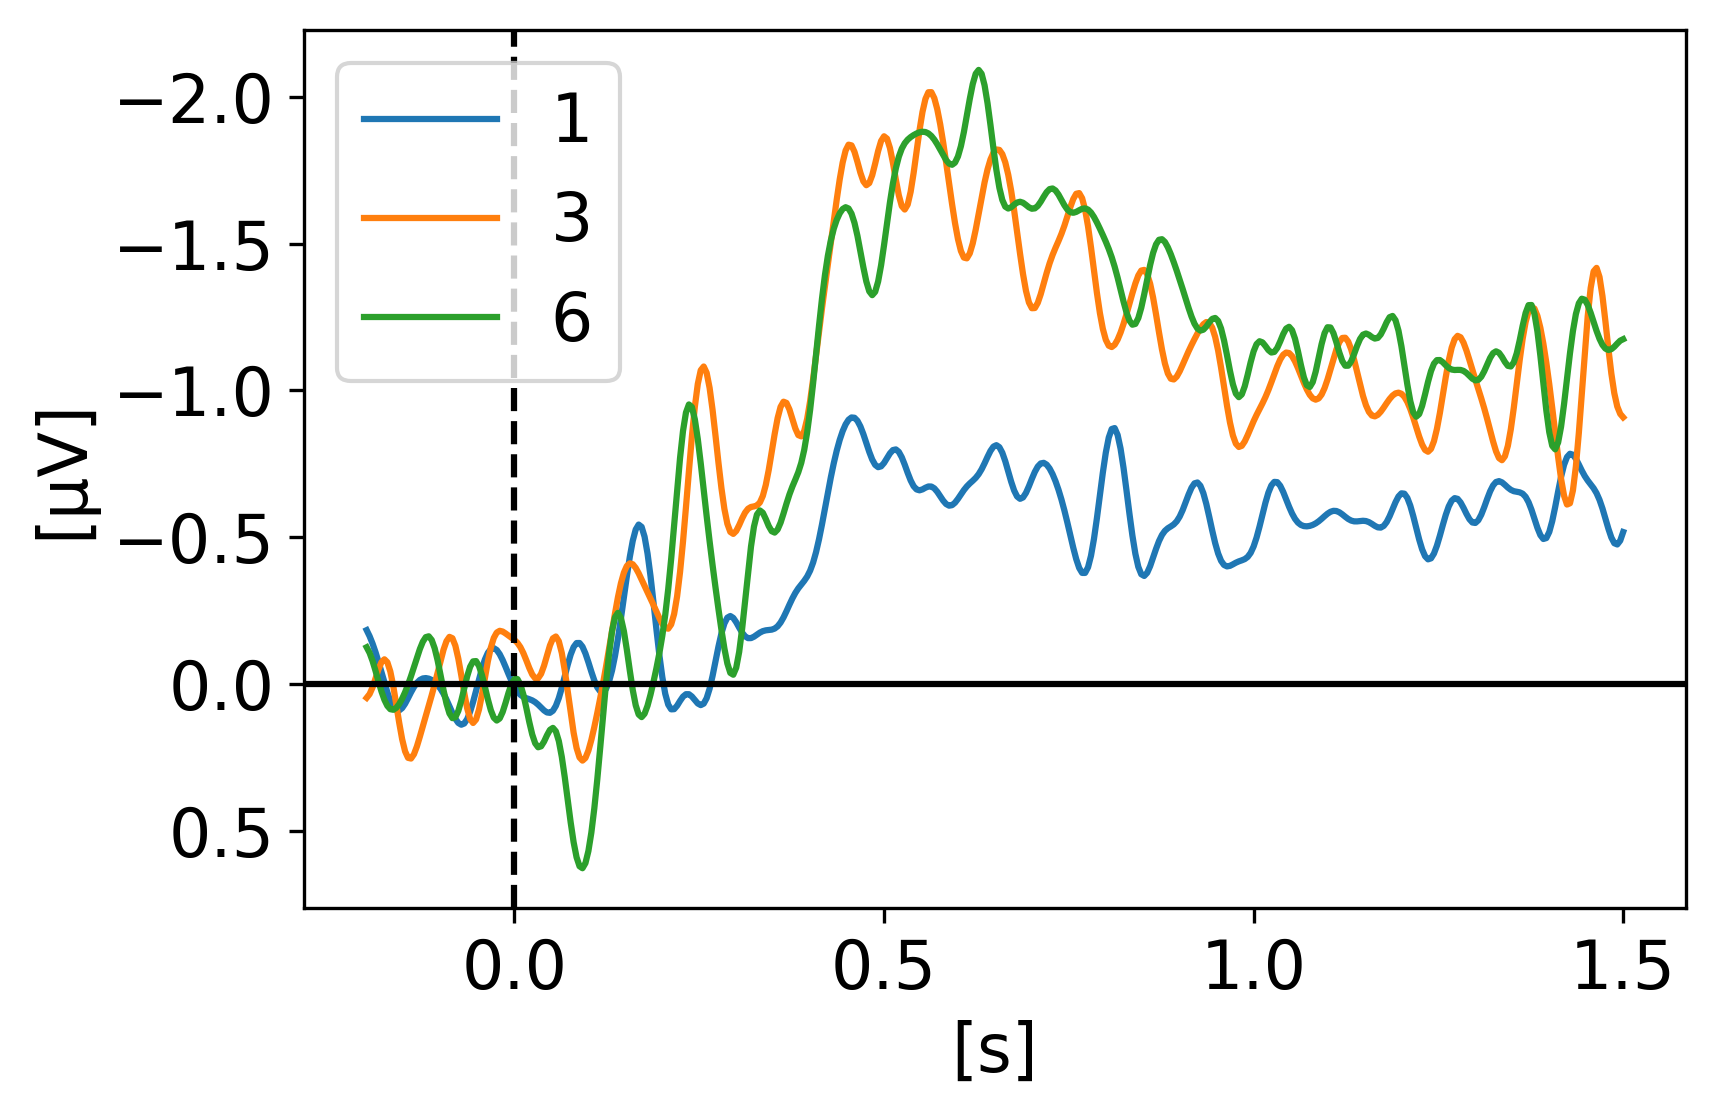

In [8]:
cda_all = dict()

perf_accs = dict()
perf_accs['1'] = ['acc_1']
perf_accs['3'] = ['acc_2','acc_3']
perf_accs['6'] = ['acc_3','acc_4','acc_5','acc_6']

for cond in cda_dict_all[list(cda_dict_all.keys())[0]].keys():
    cda_all[cond] = dict()

    for perf in accs:
        if perf != 'acc_0':
            for f in cda_dict_all.keys():
                ldict = cda_dict_all[f][cond]['left']
                rdict = cda_dict_all[f][cond]['right']
                if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):
                    cda_dict_cur = (cda_dict_all[f][cond]['left'][perf] + cda_dict_all[f][cond]['right'][perf])/2
                    cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
                else:
                    if int(perf[4]) <= int(cond):
                        print("==== SKIPPED: 0 points! (File: {} - Cond: {} - Acc: {})".format(str(f), str(cond), str(perf)))

# Plot
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(6, 4), dpi=300)
plt.plot(times, np.nanmean(cda_all['1'] * 1e6, 0), label='1')
plt.plot(times, np.nanmean(cda_all['3'] * 1e6, 0), label='3')
plt.plot(times, np.nanmean(cda_all['6'] * 1e6, 0), label='6')
plt.axvline(x=0, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[s]')

plt.tight_layout()
fig.savefig("./{}-reprod.png".format(study_id), dpi=300, format='png')

## Save CDA Data

In [23]:
data_pickle = dict()
data_pickle['times'] = times
data_pickle['CDA'] = cda_dict_all
data_pickle['epochs'] = epochs_dict_all
data_pickle['report'] = report
data_pickle['report_perf'] = perf_report_all

with open("{}_clean-20hz.pkl".format(study_id),"wb") as f:
    pickle.dump(data_pickle, f)

## Load CDA Data

In [5]:
with open("{}_clean-20hz.pkl".format(study_id),"rb") as f:
    data_pickle = pickle.load(f)
    
times = data_pickle['times']
cda_dict_all = data_pickle['CDA']
epochs_dict_all = data_pickle['epochs']
report = data_pickle['report']
perf_report_all = data_pickle['report_perf']

len(cda_dict_all)

31

## Analysis - Bad Perf Trials

==== SKIPPED: 0 points! (File: 15_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 3_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 29_DWR_Bilateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 2_DWR_BiLateral.set - Cond: 1)
==== SKIPPED: 0 points! (File: 13_DWR_Bilateral.set - Cond: 3)
==== SKIPPED: 0 points! (File: 15_DWR_Bilateral.set - Cond: 3)
==== SKIPPED: 0 points! (File: 16_DWR_Bilateral.set - Cond: 3)
==== SKIPPED: 0 points! (File: 23_DWR_Bilateral.set - Cond: 3)
==== SKIPPED: 0 points! (File: 27_DWR_Bilateral.set - Cond: 3)
==== SKIPPED: 0 points! (File: 3_DWR_Bilateral.set - Cond: 3)
==== SKIPPED: 0 points! (File: 6_DWR_Bilateral.set - Cond: 3)
==== SKIPPED: 0 points! (File: 7_DWR_Bilateral.set - Cond: 3)
==== SKIPPED: 0 points! (File: 9_DWR_Bilateral.set - Cond: 3)
==== SKIPPED: 0 points! (File: 13_DWR_Bilateral.set - Cond: 6)
==== SKIPPED: 0 points! (File: 17_DWR_Bilateral.set - Cond: 6)
==== SKIPPED: 0 points! (File: 3_DWR_Bilateral.set - Cond: 6)

Text(0.5, 0, '[s]')

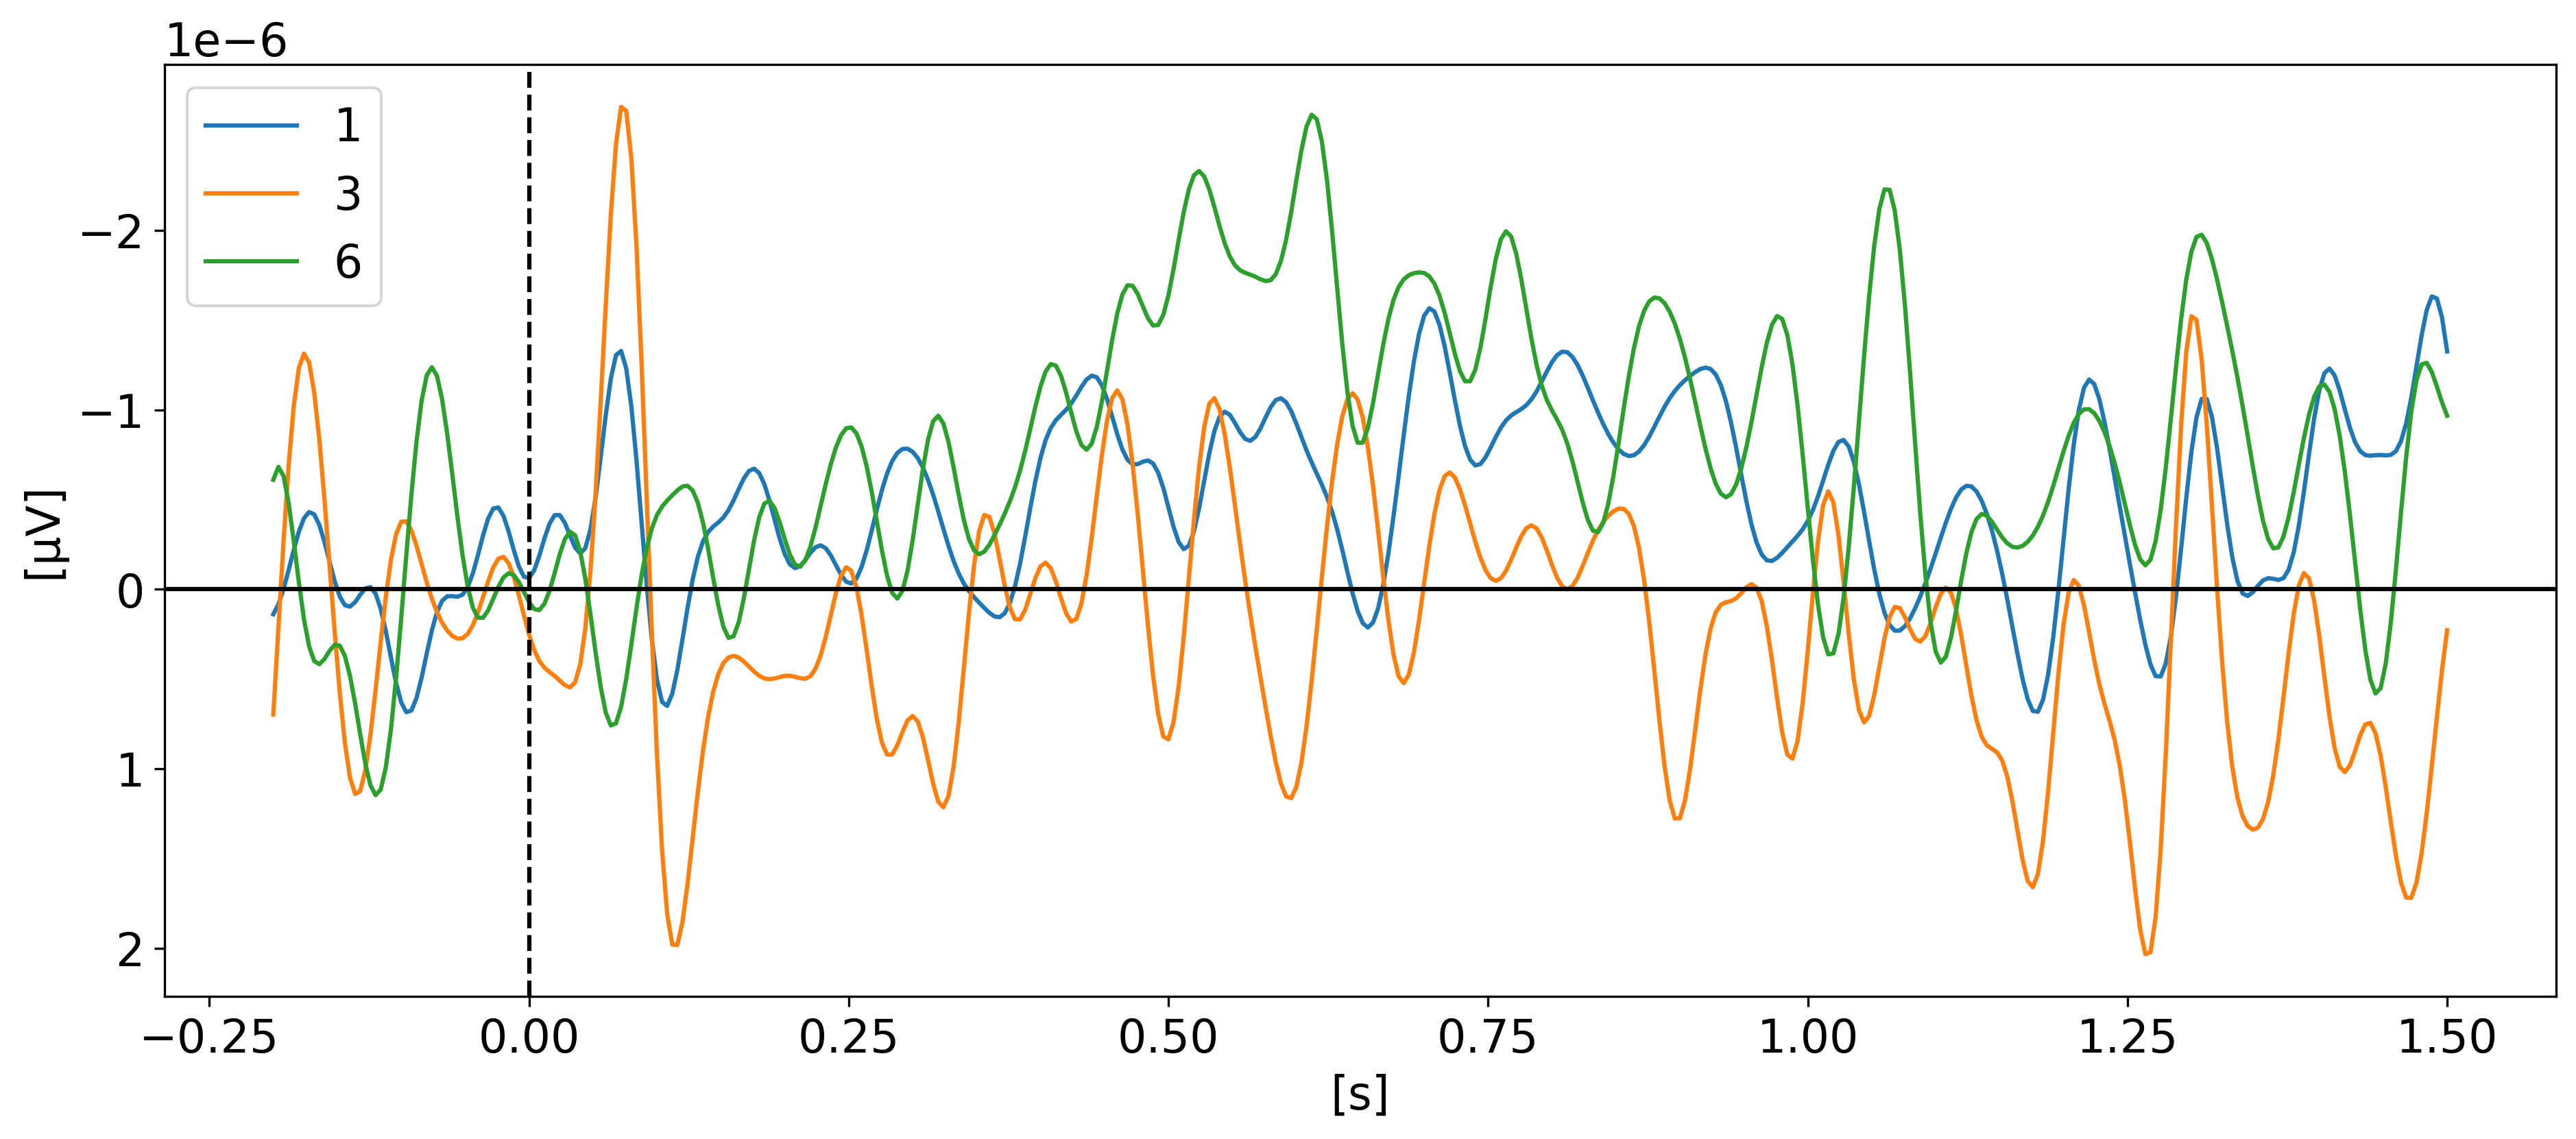

In [25]:
cda_all_bad = dict()

perf_accs = dict()
perf_accs['1'] = ['acc_1']
perf_accs['3'] = ['acc_2','acc_3']
perf_accs['6'] = ['acc_3','acc_4','acc_5','acc_6']

for cond in cda_dict_all[list(cda_dict_all.keys())[0]].keys():
    cda_all_bad[cond] = dict()

    #perf = 'acc_3'
    #for perf in perf_accs[cond]:
    for perf in accs:
        if perf == 'acc_0':
            for f in cda_dict_all.keys():
                ldict = cda_dict_all[f][cond]['left']
                rdict = cda_dict_all[f][cond]['right']
                if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):
                    cda_dict_cur = (cda_dict_all[f][cond]['left'][perf] + cda_dict_all[f][cond]['right'][perf])/2
                    cda_all_bad[cond] = np.vstack([cda_all_bad[cond], cda_dict_cur]) if len(cda_all_bad[cond]) else cda_dict_cur
                else:
                    print("==== SKIPPED: 0 points! (File: {} - Cond: {})".format(str(f), str(cond)))

# Plot
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(15, 6), dpi=300)
plt.plot(times, np.nanmean(cda_all_bad['1'], 0), label='1')
plt.plot(times, np.nanmean(cda_all_bad['3'], 0), label='3')
plt.plot(times, np.nanmean(cda_all_bad['6'], 0), label='6')
plt.axvline(x=0, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[s]')

## Analysis - Show Spread per subject

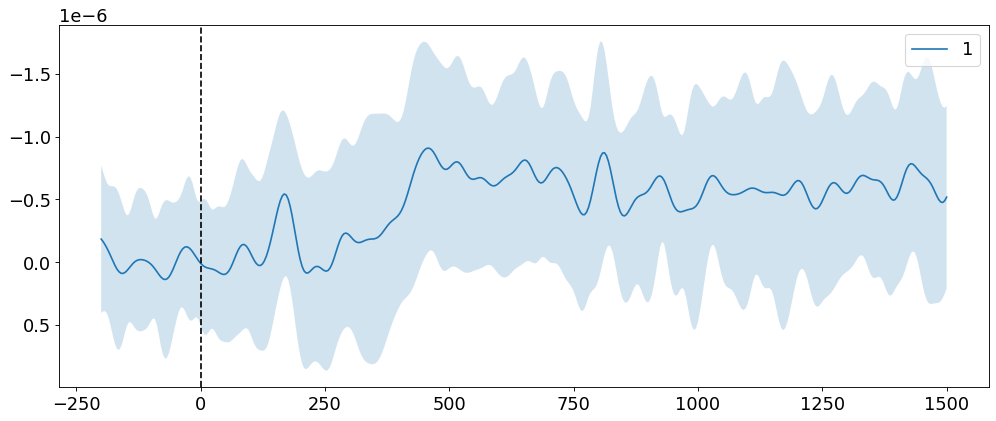

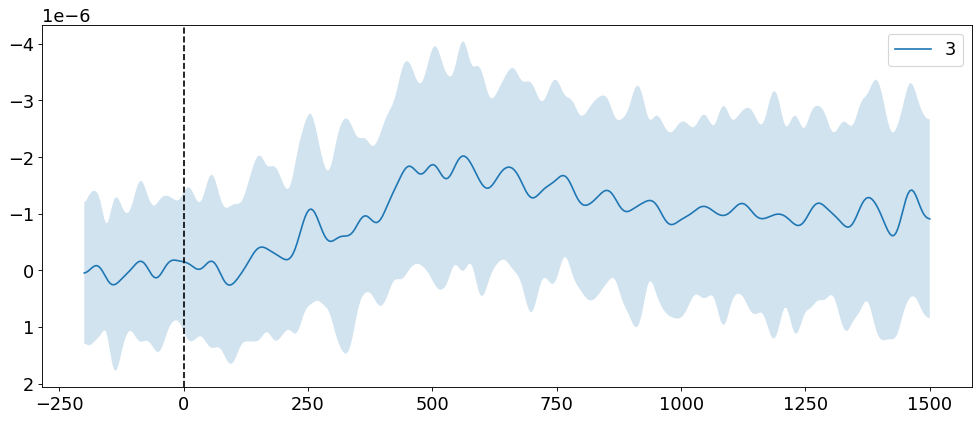

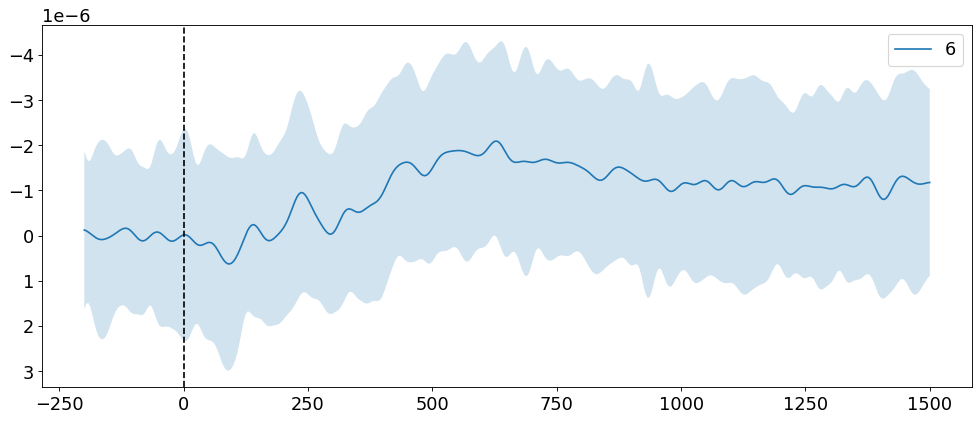

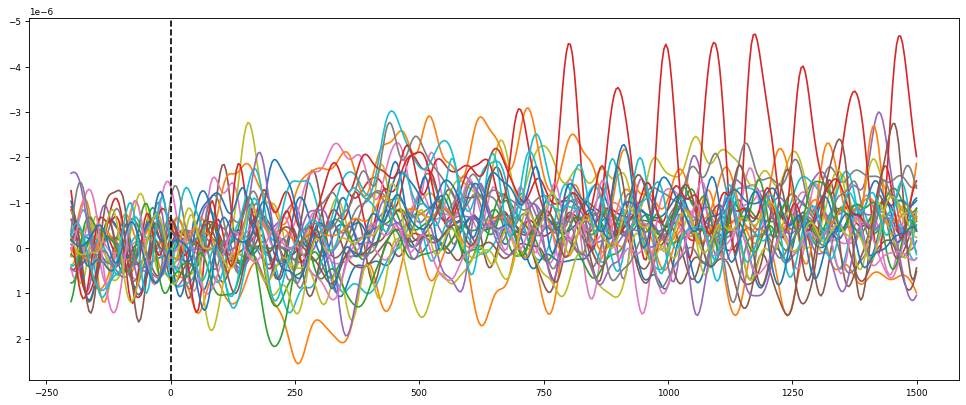

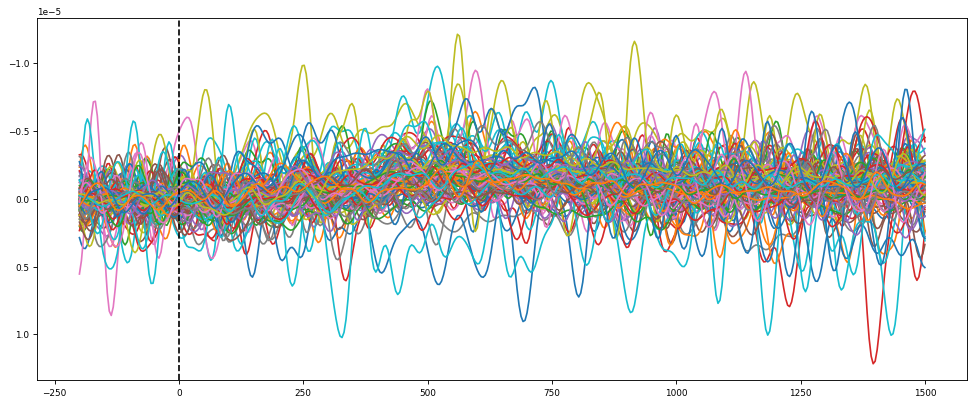

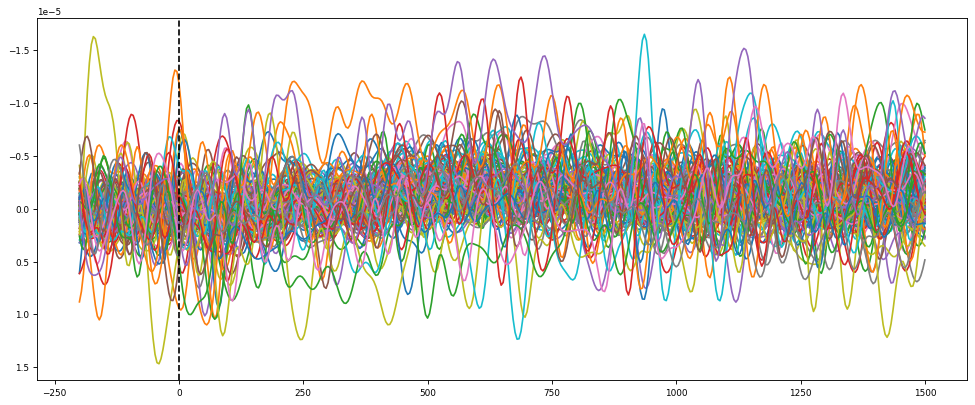

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_11816/601095652.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, len(conds), figsize=(15,6))


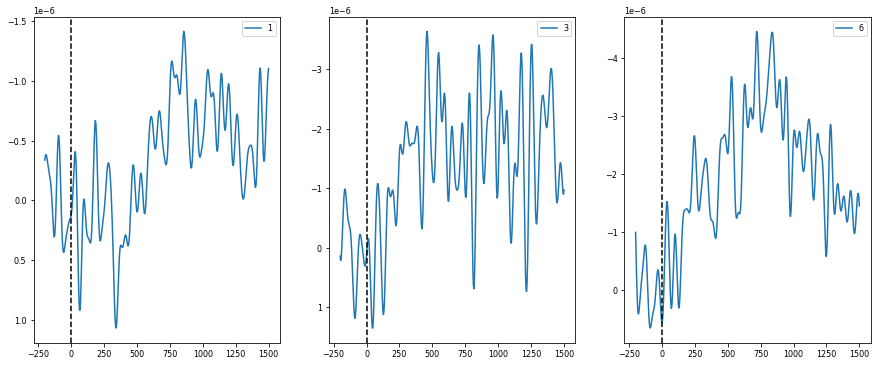

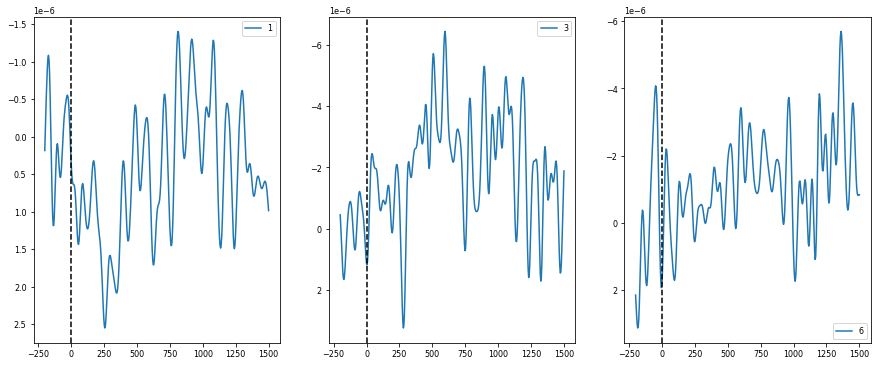

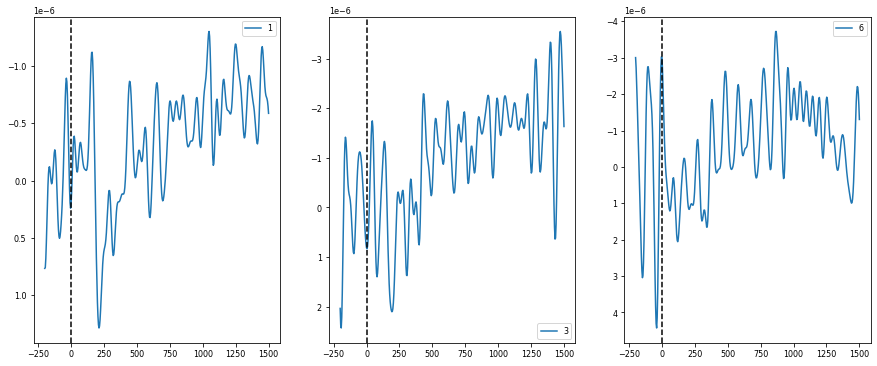

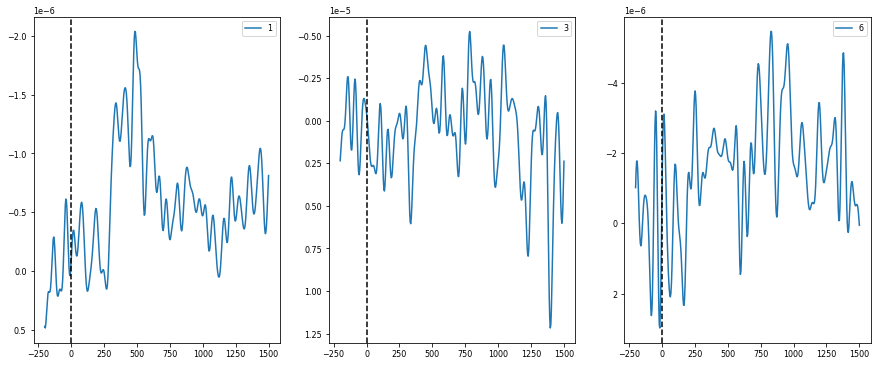

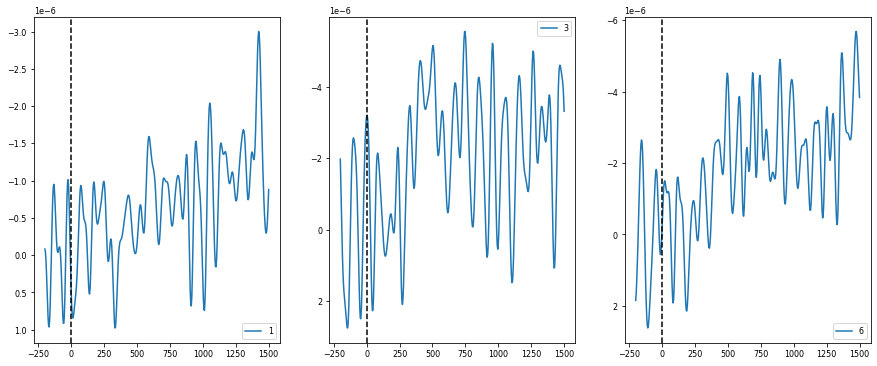

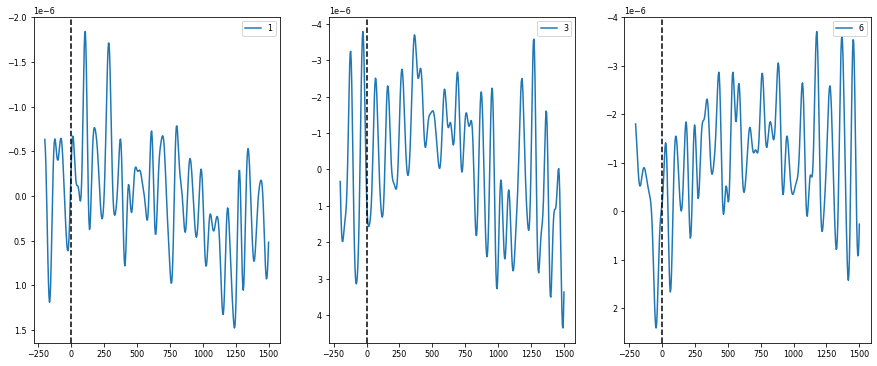

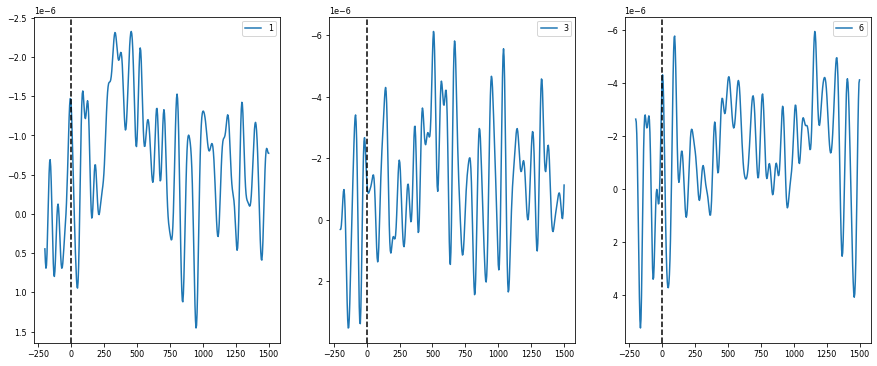

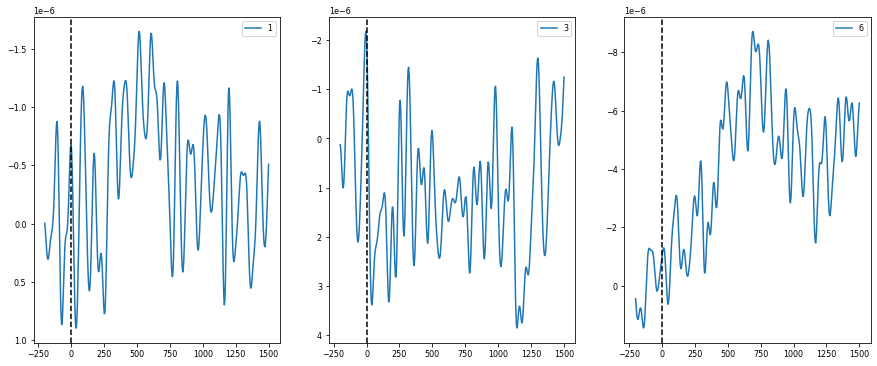

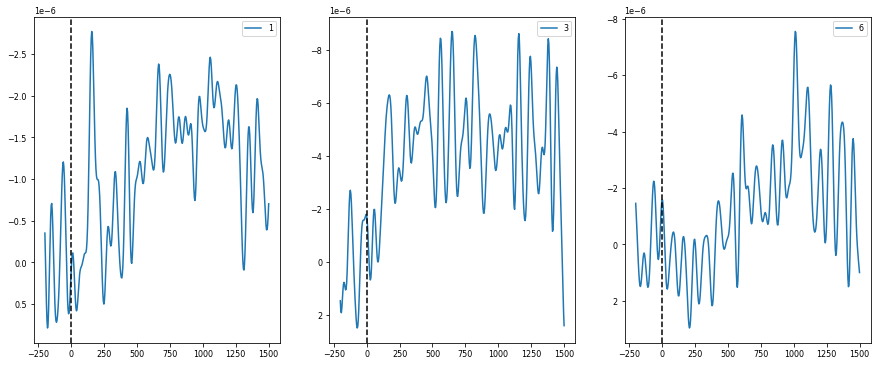

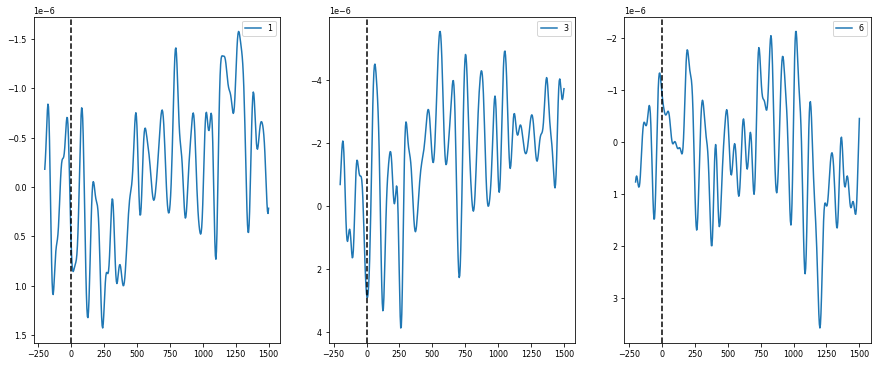

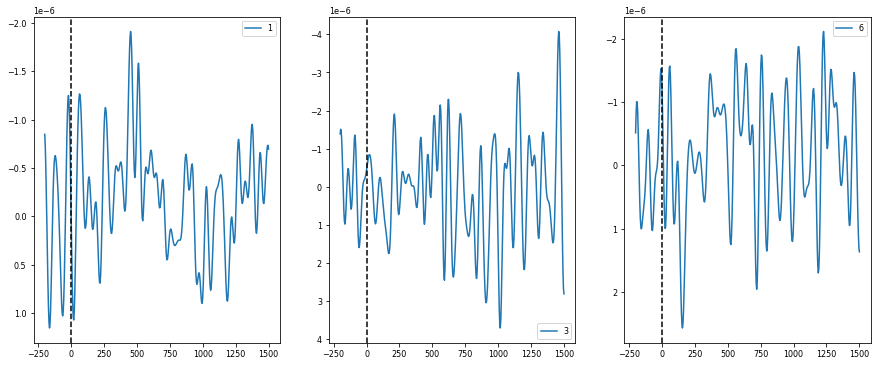

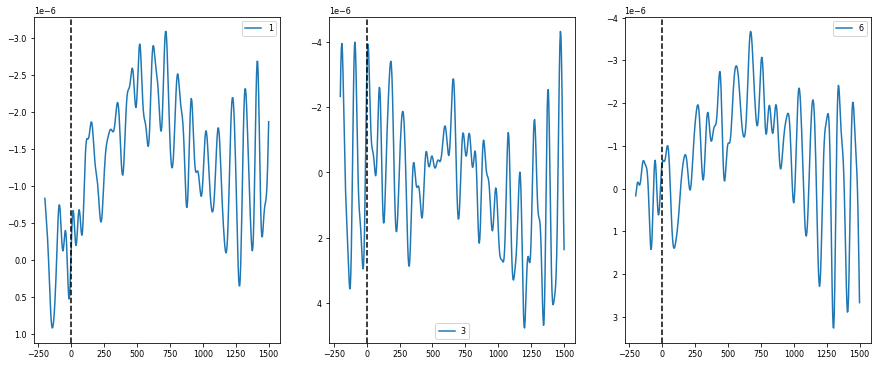

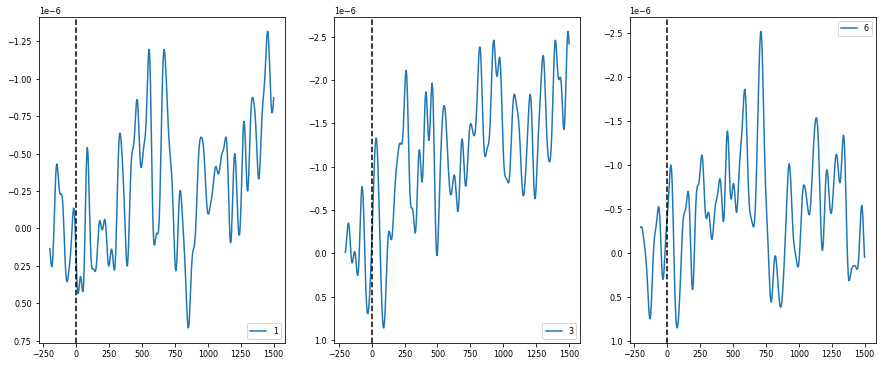

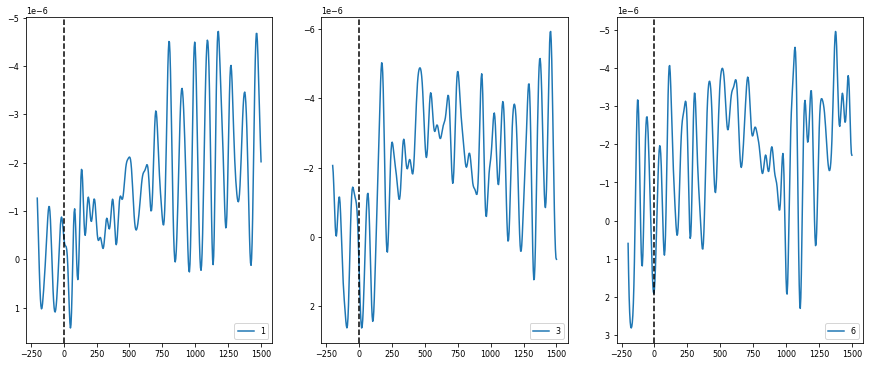

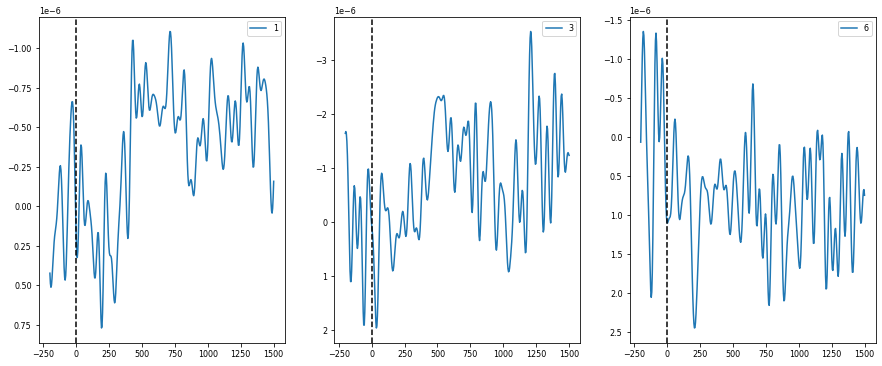

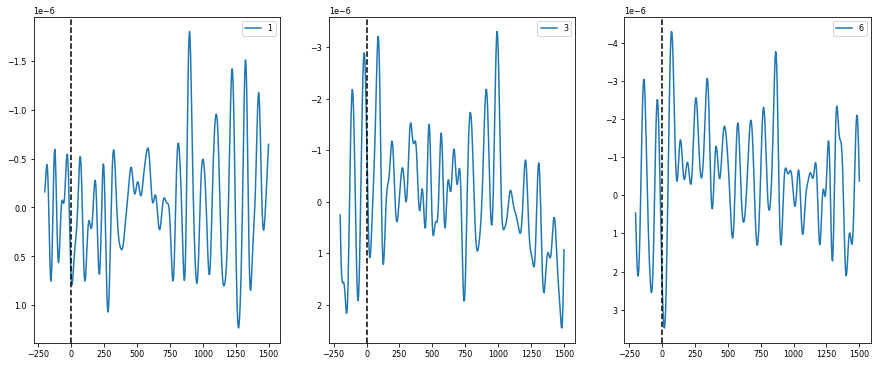

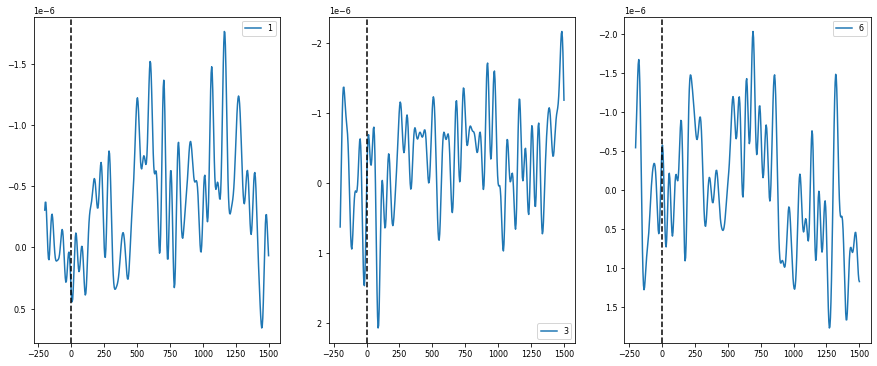

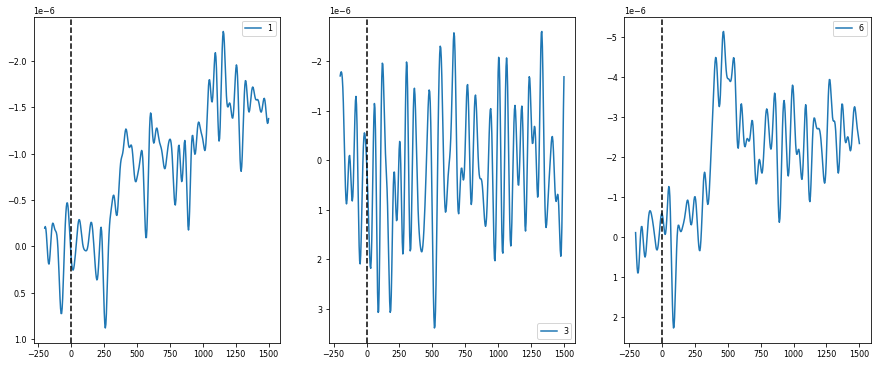

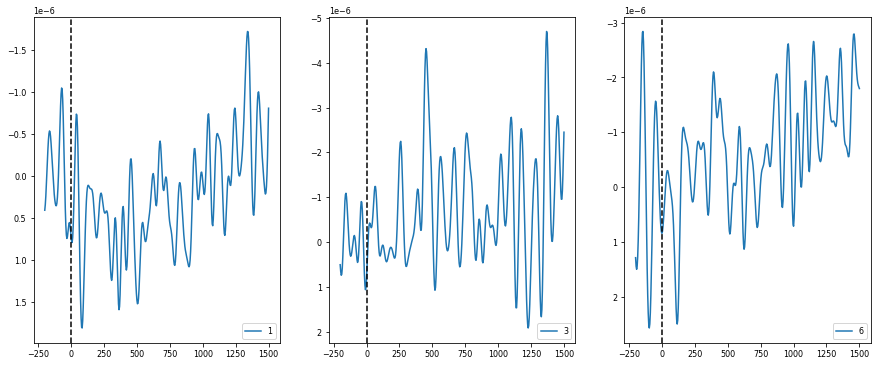

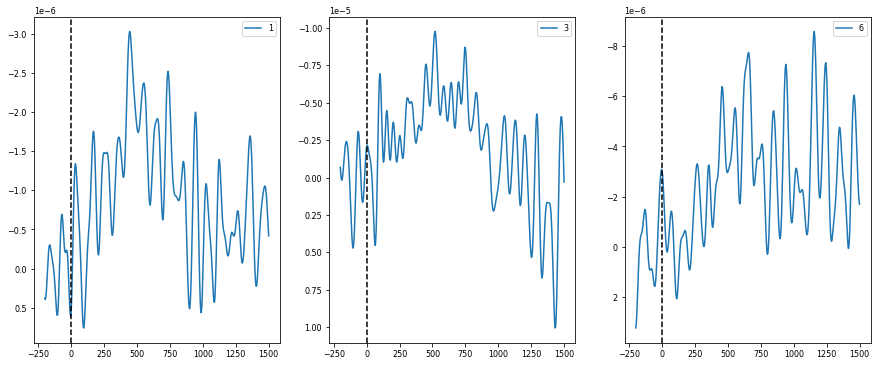

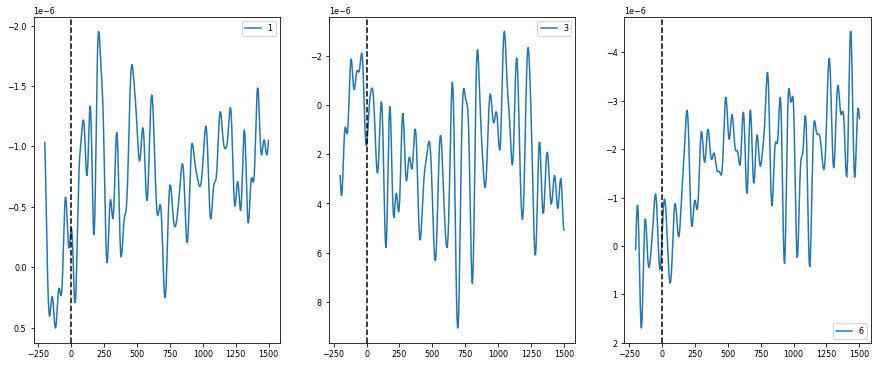

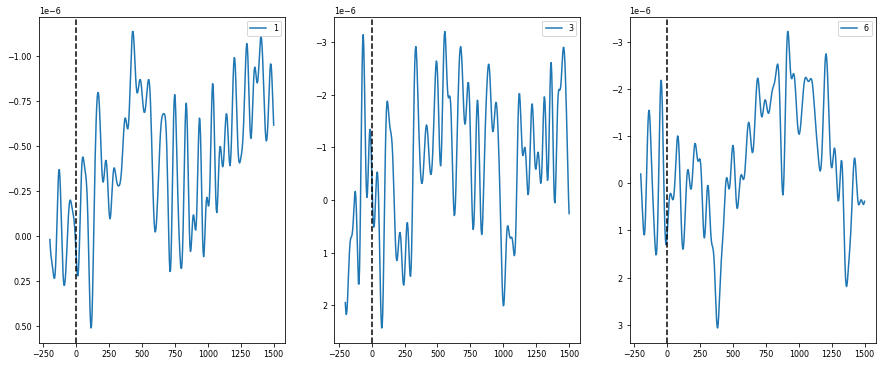

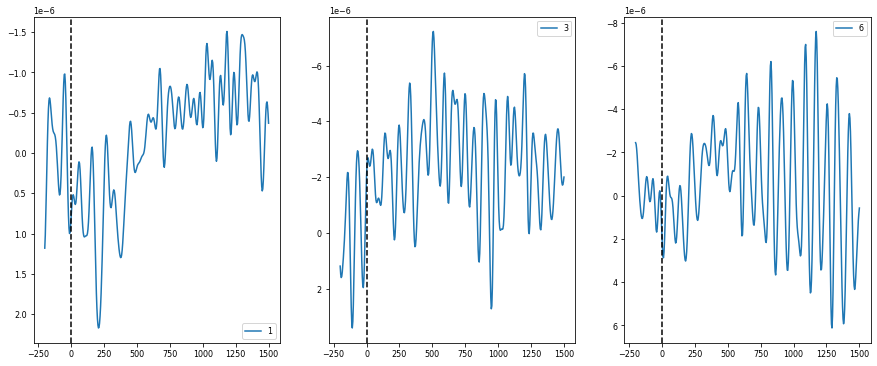

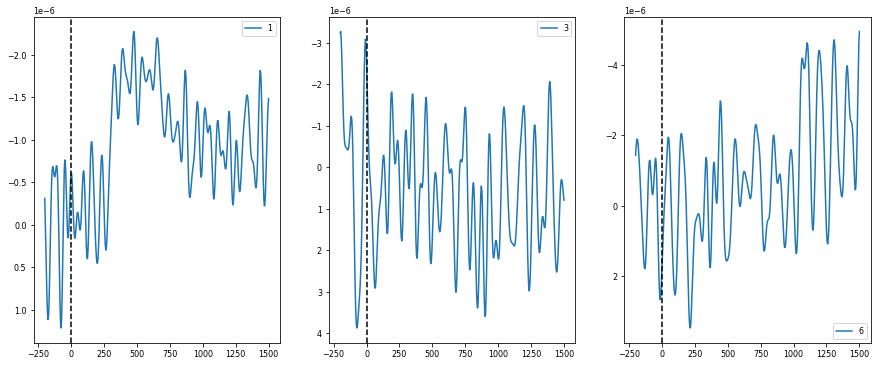

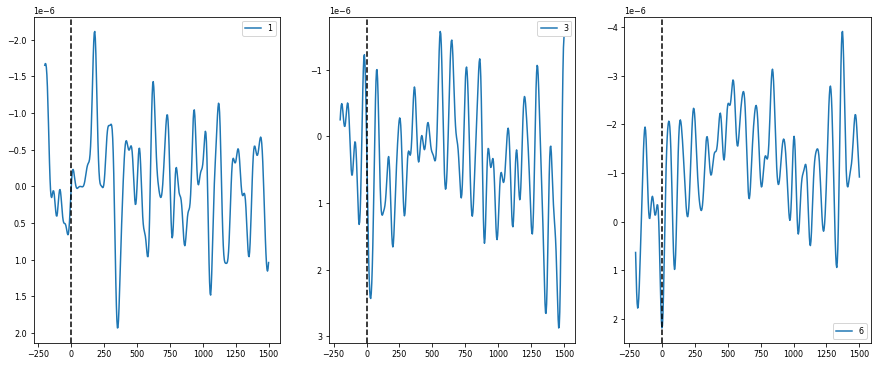

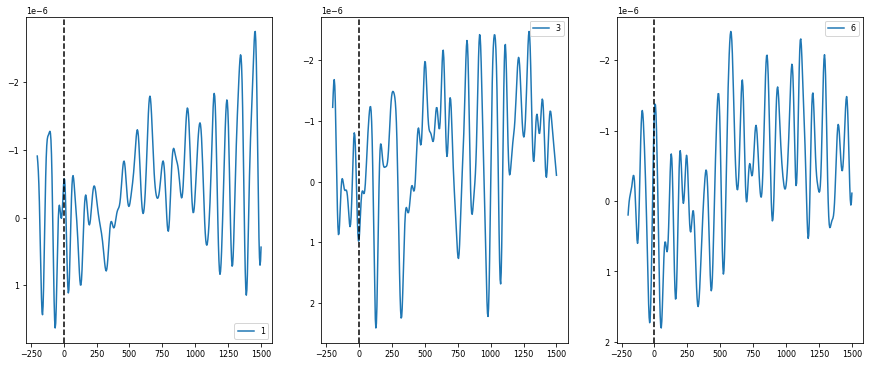

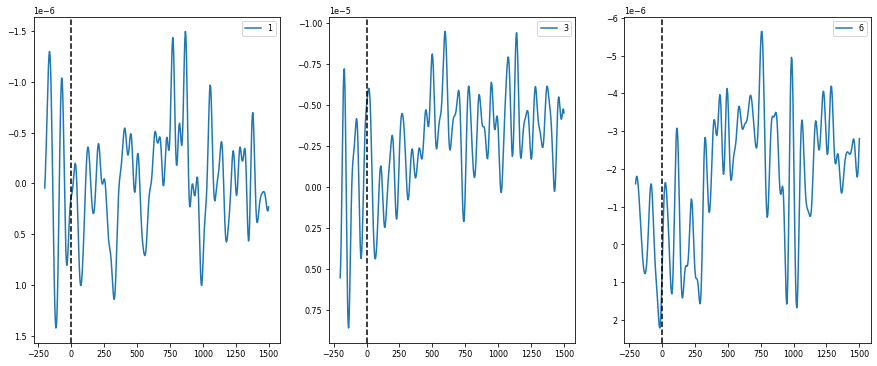

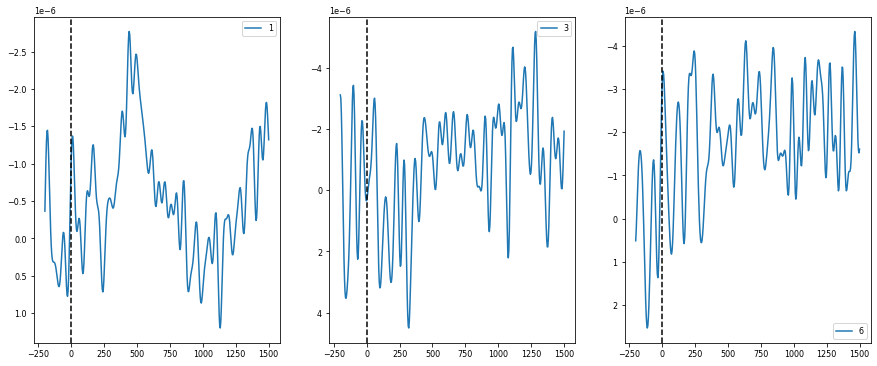

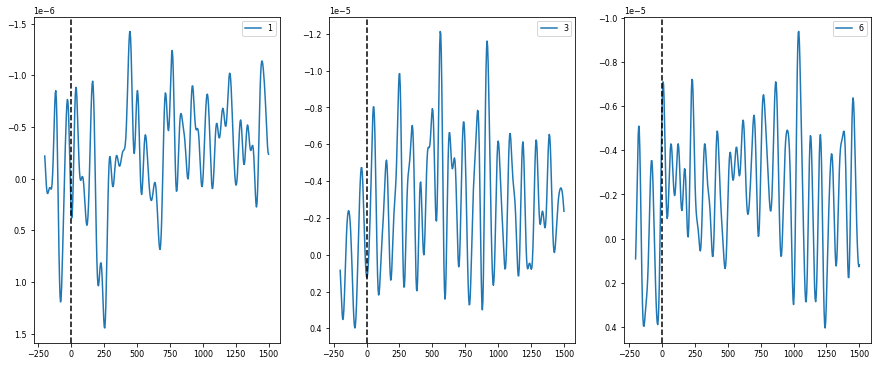

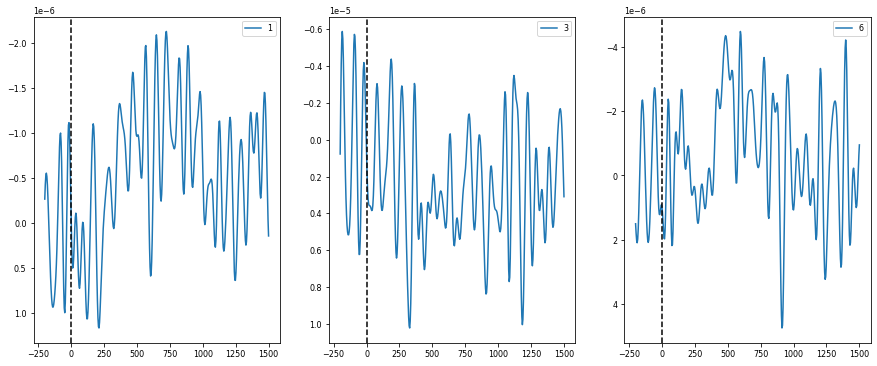

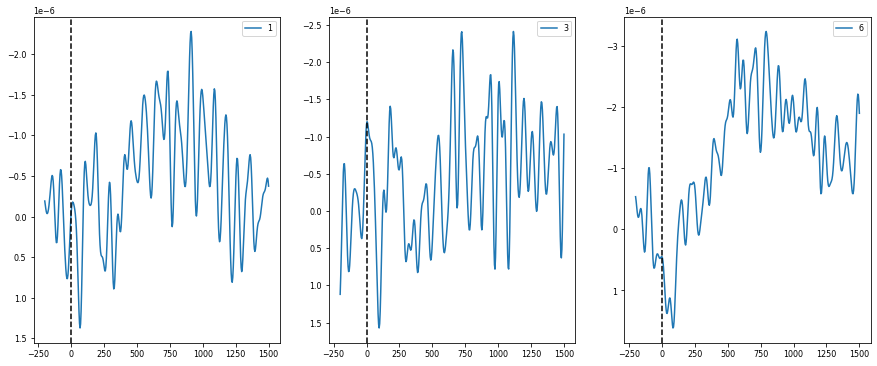

In [29]:
plt.rcParams.update({'font.size': 16})
for cond in conds:
    plt.figure(figsize=(15, 6), dpi=80)
    means = np.nanmean(cda_all[cond], 0)
    stds = np.nanstd(cda_all[cond], 0)
    plt.plot((times * 1000), means, label=cond)
    plt.fill_between((times * 1000), means-stds,means+stds,alpha=.2)

    plt.axvline(x=0, color='k', linestyle='--')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

plt.rcParams.update({'font.size': 8})
for cond in conds:
    plt.figure(figsize=(15, 6), dpi=80)
    for i in range(len(cda_all[cond])):
        plt.plot((times * 1000), cda_all[cond][i,:], label='{}'.format(i))

    plt.axvline(x=0, color='k', linestyle='--')
    plt.gca().invert_yaxis()
    #plt.legend()
    plt.show()

plt.rcParams.update({'font.size': 8})
#plt.figure(figsize=(15, 6), dpi=80)
for subject in range(len(cda_all[conds[0]])):
    fig, axs = plt.subplots(1, len(conds), figsize=(15,6))
    for i, cond in enumerate(conds):
        axs[i].plot((times * 1000), cda_all[cond][subject,:], label='{}'.format(cond))
        axs[i].axvline(x=0, color='k', linestyle='--')
        axs[i].invert_yaxis()
        axs[i].legend()
        
plt.show()

## Analysis - Performance Report (CDA per Subject)

In [14]:
report = report.loc[:,~report.columns.duplicated()]
report

1    3    6 left right acc_0 acc_1 acc_2 acc_3 acc_4  \
10_DWR_Bilateral.set  230  228  230  344   344    34   269   111   233    31   
11_DWR_Bilateral.set  200  200  198  299   299    43   247   100   172    28   
12_DWR_Bilateral.set  200  201  200  301   300    24   261   152   141    20   
13_DWR_Bilateral.set  271  270  270  405   406    10   278    78   349    71   
14_DWR_Bilateral.set  196  197  196  292   297    24   258   132   162    12   
15_DWR_Bilateral.set   97   95   98  145   145    15   137    45    80    11   
16_DWR_Bilateral.set  230  230  231  345   346    29   252   114   217    56   
18_DWR_Bilateral.set  200  200  200  300   300    14   250   135   175    23   
19_DWR_Bilateral.set  230  231  230  346   345    27   271   113   224    44   
1_DWR_Bilateral.set   200  202  200  302   300    18   241   145   180    15   
20_DWR_Bilateral.set  210  210  210  315   315    22   278   170   135    21   
21_DWR_Bilateral.set  138  138  137  209   204    29   182    91   101     8   
22_DWR_Bilateral.set  241  240  240  360   361    61   364   180   108     8   
23_DWR_Bilateral.set  250  250  250  375   375    28   322   181   196    22   
24_DWR_Bilateral.set  240  240  240  360   360    45   275   195   183    20   
25_DWR_Bilateral.set  200  200  200  300   300    32   263    91   174    28   
26_DWR_Bilateral.set  181  180  181  272   270    55   288   120    72     6   
27_DWR_Bilateral.set  230  230  230  345   345    11   257    76   271    53   
28_DWR_Bilateral.set  180  180  181  271   270    67   255   108    98     9   
17_DWR_Bilateral.set  237  237  238  358   354     7   254   108   256    60   
3_DWR_Bilateral.set   269  266  267  402   400     3   269    36   338   100   
29_DWR_Bilateral.set  210  210  210  315   315     7   232    85   248    48   
2_DWR_BiLateral.set   210  210  211  315   316    22   270   124   181    25   
30_DWR_Bilateral.set  220  220  220  330   330    18   252   104   231    42   
31_DWR_Bilateral.set  241  244  241  363   363    33   308   111   227    32   
4_DWR_Bilateral.set   246  244  241  365   366    78   311   183   141    16   
5_DWR_Bilateral.set   196  196  195  295   292    68   282   127    94    13   
6_DWR_Bilateral.set   240  240  240  360   360     9   264    97   273    60   
7_DWR_Bilateral.set   281  282  280  421   422    15   312   118   310    68   
8_DWR_Bilateral.set   220  220  220  330   330    15   238    88   264    41   
9_DWR_Bilateral.set   270  270  270  405   405    13   278    79   313    88   

                      ... 6-right-acc_6-CDA checksum notes acc_0-CDA  \
10_DWR_Bilateral.set  ...               NaN        1        0.019657   
11_DWR_Bilateral.set  ...               NaN        0     0 -1.136774   
12_DWR_Bilateral.set  ...               NaN        0     0 -0.013057   
13_DWR_Bilateral.set  ...         -2.100462        0     0  0.144819   
14_DWR_Bilateral.set  ...               NaN        0     0 -0.739938   
15_DWR_Bilateral.set  ...               NaN        0     0  1.341807   
16_DWR_Bilateral.set  ...          5.005857        0     0 -0.650692   
18_DWR_Bilateral.set  ...               NaN        0     0 -0.938660   
19_DWR_Bilateral.set  ...               NaN        0     0  1.097960   
1_DWR_Bilateral.set   ...               NaN        0     0 -1.590912   
20_DWR_Bilateral.set  ...         -2.941279        0     0  1.594120   
21_DWR_Bilateral.set  ...               NaN        0     0 -2.417567   
22_DWR_Bilateral.set  ...               NaN        0     0 -0.440672   
23_DWR_Bilateral.set  ...               NaN        0     0 -2.295563   
24_DWR_Bilateral.set  ...               NaN        0     0  0.350661   
25_DWR_Bilateral.set  ...          -2.42593        0     0  2.204269   
26_DWR_Bilateral.set  ...               NaN        0     0 -1.656054   
27_DWR_Bilateral.set  ...          0.555866        0     0 -0.455198   
28_DWR_Bilateral.set  ...         -5.836745        0     0 -1.061510   
17_DWR_Bilateral.set  .

## Subjects: Perf (Good/Bad) vs CDA Amp

In [20]:
# Pseudo K score - to be confirmed. But good "perf metric" whatsoever.
goods = report['6-acc_4'] + report['6-acc_5'] + report['6-acc_6'] #+ report['6-acc_3']
bads = report['6-acc_0'] + report['6-acc_1'] + report['6-acc_2'] + report['acc_3']

acc_perfs = goods/bads
acc_perfs

10_DWR_Bilateral.set    0.117479
11_DWR_Bilateral.set    0.125874
12_DWR_Bilateral.set    0.085821
13_DWR_Bilateral.set    0.230216
14_DWR_Bilateral.set    0.045936
15_DWR_Bilateral.set    0.088435
16_DWR_Bilateral.set    0.277193
18_DWR_Bilateral.set    0.088435
19_DWR_Bilateral.set    0.168675
1_DWR_Bilateral.set     0.060811
20_DWR_Bilateral.set    0.092937
21_DWR_Bilateral.set    0.051546
22_DWR_Bilateral.set    0.027682
23_DWR_Bilateral.set    0.067449
24_DWR_Bilateral.set    0.064516
25_DWR_Bilateral.set    0.142857
26_DWR_Bilateral.set    0.031532
27_DWR_Bilateral.set    0.215517
28_DWR_Bilateral.set    0.056522
17_DWR_Bilateral.set    0.261261
3_DWR_Bilateral.set     0.427397
29_DWR_Bilateral.set     0.18239
2_DWR_BiLateral.set     0.115254
30_DWR_Bilateral.set    0.173502
31_DWR_Bilateral.set    0.135447
4_DWR_Bilateral.set     0.059603
5_DWR_Bilateral.set     0.065574
6_DWR_Bilateral.set     0.221902
7_DWR_Bilateral.set     0.218905
8_DWR_Bilateral.set     0.160819
9_DWR_Bila

In [23]:
goods_CDA = report['6-acc_4-CDA'] + report['6-acc_5-CDA'] + report['6-acc_6-CDA'] #+ report['6-acc_3']
bads_CDA = report['6-acc_0-CDA'] + report['6-acc_1-CDA'] + report['6-acc_2-CDA'] + report['acc_3-CDA']

goods_CDA

10_DWR_Bilateral.set    -8.604628
11_DWR_Bilateral.set          NaN
12_DWR_Bilateral.set          NaN
13_DWR_Bilateral.set    -4.412179
14_DWR_Bilateral.set          NaN
15_DWR_Bilateral.set          NaN
16_DWR_Bilateral.set    -0.826025
18_DWR_Bilateral.set          NaN
19_DWR_Bilateral.set          NaN
1_DWR_Bilateral.set           NaN
20_DWR_Bilateral.set    -6.032346
21_DWR_Bilateral.set          NaN
22_DWR_Bilateral.set          NaN
23_DWR_Bilateral.set          NaN
24_DWR_Bilateral.set          NaN
25_DWR_Bilateral.set    -0.864038
26_DWR_Bilateral.set          NaN
27_DWR_Bilateral.set    -3.133005
28_DWR_Bilateral.set    -9.499367
17_DWR_Bilateral.set   -10.250468
3_DWR_Bilateral.set      0.026411
29_DWR_Bilateral.set          NaN
2_DWR_BiLateral.set           NaN
30_DWR_Bilateral.set    -5.744017
31_DWR_Bilateral.set    -9.346345
4_DWR_Bilateral.set           NaN
5_DWR_Bilateral.set           NaN
6_DWR_Bilateral.set     -5.937058
7_DWR_Bilateral.set     -3.572286
8_DWR_Bilatera

In [51]:
#goods_CDA = report[['6-acc_4-CDA','6-acc_5-CDA','6-acc_6-CDA']]
#bads_CDA = report['6-acc_0-CDA'] + report['6-acc_1-CDA'] + report['6-acc_2-CDA'] + report['acc_3-CDA']

goods_CDA = report[['6-acc_1-CDA', '6-acc_2-CDA', '6-acc_3-CDA', '6-acc_4-CDA','6-acc_5-CDA']]#,'6-acc_0-CDA', '6-acc_6-CDA']]

#np.nanmean(goods_CDA.loc['10_DWR_Bilateral.set'])
goods_CDA

6-acc_1-CDA 6-acc_2-CDA 6-acc_3-CDA 6-acc_4-CDA  \
10_DWR_Bilateral.set   -2.427731   -1.775137   -1.737903   -1.357776   
11_DWR_Bilateral.set   -1.574709   -0.828609   -1.578535    -0.60097   
12_DWR_Bilateral.set   -1.087227   -0.440412   -0.801617    1.472428   
13_DWR_Bilateral.set   -2.004004   -2.675091   -2.690617   -2.100535   
14_DWR_Bilateral.set   -2.633205   -1.939785   -1.813112   -4.084139   
15_DWR_Bilateral.set   -1.326788    -1.50029   -1.769705    0.498209   
16_DWR_Bilateral.set   -1.909937   -0.654463    -0.74819   -2.923653   
18_DWR_Bilateral.set   -5.343571   -1.151516   -1.932119   -0.440344   
19_DWR_Bilateral.set   -2.129395   -1.855797   -1.312365   -3.447569   
1_DWR_Bilateral.set     0.308762   -0.984597   -1.187159   -1.390221   
20_DWR_Bilateral.set   -0.342736    0.021197   -0.988423   -0.646102   
21_DWR_Bilateral.set    -1.05564   -2.012573   -0.984281    0.139529   
22_DWR_Bilateral.set   -0.591177   -0.212494    -0.74435      1.5064   
23_DWR_Bilateral.set   -2.201097   -1.244274    -0.42998   -3.572446   
24_DWR_Bilateral.set    0.864847   -0.080517    0.111737   -1.353856   
25_DWR_Bilateral.set   -0.401693   -1.140321   -1.647856    -0.42373   
26_DWR_Bilateral.set    0.037037   -0.776322   -1.124887    1.850861   
27_DWR_Bilateral.set   -2.698046   -1.393743   -1.934187   -1.157953   
28_DWR_Bilateral.set   -0.906814   -0.812341   -1.972303   -1.454617   
17_DWR_Bilateral.set   -3.524632   -4.279538   -2.135359   -2.640011   
3_DWR_Bilateral.set    -3.642857    0.418307   -1.551437     -0.5283   
29_DWR_Bilateral.set   -2.117743   -0.492486   -1.214002   -1.700906   
2_DWR_BiLateral.set    -0.855428   -2.162202   -0.501407    0.369521   
30_DWR_Bilateral.set    -0.78108   -1.026376    -2.51273   -2.280446   
31_DWR_Bilateral.set   -1.233624   -1.147055   -0.976276   -2.039927   
4_DWR_Bilateral.set    -1.405367   -1.524182   -0.482344    0.192444   
5_DWR_Bilateral.set    -0.707317   -1.079678    0.060794   -1.709097   
6_DWR_Bilateral.set    -2.522203   -0.938064   -1.393546   -1.270293   
7_DWR_Bilateral.set    -2.180262    -1.27442   -1.716052   -1.588107   
8_DWR_Bilateral.set    -2.382441   -2.548289   -3.260522    -1.67233   
9_DWR_Bilateral.set    -0.920397    0.181113   -0.505194   -0.825838   

                     6-acc_5-CDA  
10_DWR_Bilateral.set   -1.439571  
11_DWR_Bilateral.set    0.079562  
12_DWR_Bilateral.set   -1.346211  
13_DWR_Bilateral.set   -1.945798  
14_DWR_Bilateral.set   -1.234502  
15_DWR_Bilateral.set    -1.06469  
16_DWR_Bilateral.set   -1.187712  
18_DWR_Bilateral.set   -1.538501  
19_DWR_Bilateral.set   -3.494167  
1_DWR_Bilateral.set    -0.947606  
20_DWR_Bilateral.set   -2.444965  
21_DWR_Bilateral.set   -2.925411  
22_DWR_Bilateral.set         NaN  
23_DWR_Bilateral.set   -9.513448  
24_DWR_Bilateral.set    4.307854  
25_DWR_Bilateral.set   -0.199574  
26_DWR_Bilateral.set   -3.420271  
27_DWR_Bilateral.set   -1.782897  
28_DWR_Bilateral.set   -2.208005  
17_DWR_Bilateral.set     -2.1252  
3_DWR_Bilateral.set    -0.499643  
29_DWR_Bilateral.set    -0.71148  
2_DWR_BiLateral.set     0.331002  
30_DWR_Bilateral.set   -1.876336  
31_DWR_Bilateral.set   -1.225993  
4_DWR_Bilateral.set    -1.682467  
5_DWR_Bilateral.set    -1.595665  
6_DWR_Bilateral.set    -2.796951  
7_DWR_Bilateral.set    -1.044089  
8_DWR_Bilateral.set    -4.067669  
9_DWR_Bilateral.set    -1.630587

In [52]:
CDA_goods = []
for f in goods_CDA.index:
    CDA_goods.append(np.nanmean(goods_CDA.loc[f]))
    
CDA_goods

[-1.747623705190621,
 -0.9006521971465447,
 -0.4406078576336247,
 -2.283209090898663,
 -2.340948617438757,
 -1.0326529244337428,
 -1.4847908009880684,
 -2.0812101776497207,
 -2.4478586569915217,
 -0.8401643013389736,
 -0.8802058527075101,
 -1.3676751678213002,
 -0.010405094825210404,
 -3.392248982730205,
 0.7700129709942771,
 -0.7626346722600466,
 -0.6867163573612407,
 -1.793365047329115,
 -1.4708159284205955,
 -2.940948064730134,
 -1.160785895108382,
 -1.2473234898027619,
 -0.5637030427590088,
 -1.695393698319172,
 -1.3245749707847025,
 -0.9803830605004498,
 -1.0061927287977013,
 -1.7842113943232747,
 -1.5605860941713678,
 -2.7862499909219958,
 -0.7401806202468146]

In [55]:
Perf_goods = []
for f in acc_perfs.index:
    Perf_goods.append(acc_perfs.loc[f])
    
Perf_goods

[0.1174785100286533,
 0.1258741258741259,
 0.08582089552238806,
 0.2302158273381295,
 0.045936395759717315,
 0.08843537414965986,
 0.2771929824561403,
 0.08843537414965986,
 0.1686746987951807,
 0.060810810810810814,
 0.09293680297397769,
 0.05154639175257732,
 0.02768166089965398,
 0.06744868035190615,
 0.06451612903225806,
 0.14285714285714285,
 0.03153153153153153,
 0.21551724137931033,
 0.05652173913043478,
 0.26126126126126126,
 0.4273972602739726,
 0.18238993710691823,
 0.1152542372881356,
 0.17350157728706625,
 0.13544668587896252,
 0.059602649006622516,
 0.06557377049180328,
 0.2219020172910663,
 0.21890547263681592,
 0.1608187134502924,
 0.3377659574468085]

10_DWR_Bilateral.set    0.117479
11_DWR_Bilateral.set    0.125874
12_DWR_Bilateral.set    0.085821
13_DWR_Bilateral.set    0.230216
14_DWR_Bilateral.set    0.045936
15_DWR_Bilateral.set    0.088435
16_DWR_Bilateral.set    0.277193
18_DWR_Bilateral.set    0.088435
19_DWR_Bilateral.set    0.168675
1_DWR_Bilateral.set     0.060811
20_DWR_Bilateral.set    0.092937
21_DWR_Bilateral.set    0.051546
22_DWR_Bilateral.set    0.027682
23_DWR_Bilateral.set    0.067449
24_DWR_Bilateral.set    0.064516
25_DWR_Bilateral.set    0.142857
26_DWR_Bilateral.set    0.031532
27_DWR_Bilateral.set    0.215517
28_DWR_Bilateral.set    0.056522
17_DWR_Bilateral.set    0.261261
3_DWR_Bilateral.set     0.427397
29_DWR_Bilateral.set     0.18239
2_DWR_BiLateral.set     0.115254
30_DWR_Bilateral.set    0.173502
31_DWR_Bilateral.set    0.135447
4_DWR_Bilateral.set     0.059603
5_DWR_Bilateral.set     0.065574
6_DWR_Bilateral.set     0.221902
7_DWR_Bilateral.set     0.218905
8_DWR_Bilateral.set     0.160819
9_DWR_Bila

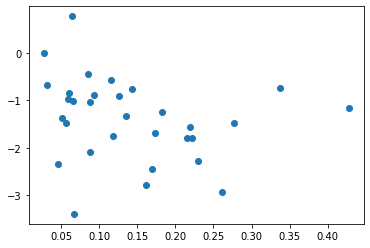

In [56]:
print(acc_perfs)
print(CDA_goods)

x = Perf_goods
y = CDA_goods

print('----------------------------------------------------')
print('Corr Acc/Perf vs CDA Amp (Good): {}'.format(scipy.stats.pearsonr(x,y)))
print('----------------------------------------------------')

plt.scatter(x=x, y=y)

In [ ]:
plt.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(1, len(conds), figsize=(15,4))

for i, cond in enumerate(conds):
    x = range(len(report['{}-right-good-CDA'.format(cond)]))
    
    # Good
    y = (report['{}-right-good-CDA'.format(cond)] + report['{}-left-good-CDA'.format(cond)]) / 2
    axs[i].scatter(x=x, y=y, color='blue', label='Good')
    axs[i].axhline(y=np.nanmean(y), color='blue', linestyle='--')
    # Bad
    y = (report['{}-right-bad-CDA'.format(cond)] + report['{}-left-bad-CDA'.format(cond)]) / 2
    axs[i].scatter(x=x, y=y, color='red', label='Bad')
    axs[i].axhline(y=np.nanmean(y), color='red', linestyle='--')
    
    axs[i].set_title('{} G vs B'.format(cond))
    axs[i].invert_yaxis()
    
axs[0].legend()
axs[0].set_ylabel('Mean CDA Amplitude')
    

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# Data
goods = np.array(report['good-CDA'])
bads = np.array(report['bad-CDA'])

# Calculate the average
goods_mean = np.nanmean(goods)
bads_mean = np.nanmean(bads)

# Calculate the standard deviation
goods_std = np.nanstd(goods)
bads_std = np.nanstd(bads)

# Define labels, positions, bar heights and error bar heights
labels = ['Good', 'Bad']
x_pos = np.arange(len(labels))
CTEs = [goods_mean, bads_mean]
error = [goods_std, bads_std]

# Build the plot
axs[0].bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
axs[0].set_ylabel('Mean Amp')
axs[0].set_xticks(x_pos)
axs[0].set_xticklabels(labels)
axs[0].set_title('Mean Amp vs # Perf')
axs[0].invert_yaxis()
#ax.yaxis.grid(True)

x = range(len(report['good-CDA']))
axs[1].scatter(x=x, y=report['good-CDA'], color='blue')
axs[1].axhline(y=np.nanmean(report['good-CDA']), color='blue', linestyle='--')
axs[1].scatter(x=x, y=report['bad-CDA'], color='red')
axs[1].axhline(y=np.nanmean(report['bad-CDA']), color='red', linestyle='--')

#plt.tight_layout()
plt.show()

import scipy
x = []
y = []
for p in perfs:
    for value in report['{}-CDA'.format(p)]:
        if p == 'good':
            x.append(1)
        else:
            x.append(2)
        y.append(value)

print('Corr Perf vs CDA Amp: {}'.format(scipy.stats.pearsonr(x,y)))

## Subjects: Condition vs CDA Amp

In [ ]:
plt.rcParams.update({'font.size': 12})

data_conds = dict()
for cond in conds:
    data_conds[cond] = dict()
    data_conds[cond]['data'] = np.array(report['{}-good-CDA'.format(cond)])
    data_conds[cond]['mean'] = np.nanmean(data_conds[cond]['data'])
    data_conds[cond]['std'] = np.nanstd(data_conds[cond]['data'])
    
labels = conds
x_pos = np.arange(len(labels))
CTEs = [data_conds[cond]['mean'] for cond in conds]
error = [data_conds[cond]['std'] for cond in conds]

fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean Amp')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Cond vs CDA Amp')
ax.invert_yaxis()
#ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Pearson's Correlation
import scipy
x = []
y = []
for i, ss in enumerate(['int', 'no_int']):
    for value in report['{}-good-CDA'.format(ss)]:
        x.append(i)
        y.append(value)

print('Corr int & no_int vs CDA Amp: {}'.format(scipy.stats.pearsonr(x,y)))

## Subjects: Side (Left/Right) vs CDA Amp

In [ ]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1, 2, figsize=(15,6))

x = range(len(report['left-good-CDA']))
y= report['left-good-CDA']
axs[0].scatter(x=x, y=y, color='blue')
axs[0].axhline(y=np.nanmean(y), color='blue', linestyle='--')
x = range(len(report['left-bad-CDA']))
y= report['left-bad-CDA']
axs[0].scatter(x=x, y=y, color='red')
axs[0].axhline(y=np.nanmean(y), color='red', linestyle='--')
axs[0].set_title('Left Good vs Bad')

x = range(len(report['right-good-CDA']))
y= report['right-good-CDA']
axs[1].scatter(x=x, y=y, color='blue')
axs[1].axhline(y=np.nanmean(y), color='blue', linestyle='--')
x = range(len(report['right-bad-CDA']))
y= report['right-bad-CDA']
axs[1].scatter(x=x, y=y, color='red')
axs[1].axhline(y=np.nanmean(y), color='red', linestyle='--')
axs[1].set_title('Right Good vs Bad')

x = []
y = []
for i, side in enumerate(sides):
    for value in report['{}-good-CDA'.format(side)]:
        x.append(i)
        y.append(value)

print('Corr Side vs CDA Amp: {}'.format(scipy.stats.pearsonr(x,y)))

## Subjects: Accuracy / Performance vs CDA Amp

In [ ]:
plt.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(1, len(conds), figsize=(15,4))

for i, cond in enumerate(conds):
    goods = (report['{}-left-good'.format(cond)] + report['{}-right-good'.format(cond)])/2
    bads = (report['{}-left-bad'.format(cond)] + report['{}-right-bad'.format(cond)])/2
    x = goods / (goods + bads)
    y = report['{}-left-good-CDA'.format(cond)] + report['{}-right-good-CDA'.format(cond)]
    axs[i].scatter(x=x, y=y, color='blue')
    axs[i].invert_yaxis()
    axs[i].set_title('{}'.format(cond))
    
    print('Corr Perf Acc ~ {}: {}'.format(cond, scipy.stats.pearsonr(x,y)))

axs[0].set_ylabel('CDA Mean Amp')

## Trials: Conditions vs Amp

In [ ]:
plt.figure(figsize=(15, 6), dpi=80)

for i, cond in enumerate(conds):
    y1 = []
    for f in perf_report_all.keys():
        for side in sides:
            for value in perf_report_all[f][cond][side]['good']:
                y1.append(value)
    x1 = range(len(y1))

    plt.scatter(x=x1, y=y1, label='{} Target(s)'.format(cond))

plt.ylim(-2.5*1e-5,2.5*1e-5)
plt.legend()
plt.show()

## Trials: Good vs Bad

In [ ]:
plt.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(1, len(conds), figsize=(15,6))

for i, cond in enumerate(conds):
    y1 = []
    for f in perf_report_all.keys():
        for value in perf_report_all[f][cond]['left']['good']:
            y1.append(value)
        for value in perf_report_all[f][cond]['right']['good']:
            y1.append(value)
    x1 = range(len(y1))

    y2 = []
    for f in perf_report_all.keys():
        if 'bad' in perf_report_all[f][cond]['left'].keys():
            for value in perf_report_all[f][cond]['left']['bad']:
                y2.append(value)
        if 'bad' in perf_report_all[f][cond]['right'].keys():
            for value in perf_report_all[f][cond]['right']['bad']:
                y2.append(value)
    x2 = range(len(y2))

    axs[i].scatter(x=x1, y=y1, label='Good Perf Trials')
    axs[i].scatter(x=x2, y=y2, label='Bad Perf Trials')
    axs[i].legend()
    axs[i].set_ylim(-2.5*1e-5,2.5*1e-5)
    axs[i].set_title('{} Target(s)'.format(cond))

    nb_outliers = len([val for val in (y1 + y2) if ((val*1e5) > 2.5) or ((val*1e5) < -2.5)])
    print('Cond = {} Targets: {} Good Perf Trials vs {} Bad Perf Trials, with {} outliers on graph.'.format(cond, len(y1), len(y2), nb_outliers))

axs[1].set_xlabel('Trial #')
axs[0].set_ylabel('CDA mean amplitude')
#fig.tight_layout(pad=1.0)

## Trials: Left vs Right

In [ ]:
fig, axs = plt.subplots(1, len(conds), figsize=(15,6))

for i, cond in enumerate(conds):
    y1 = []
    for f in perf_report_all.keys():
        for value in perf_report_all[f][cond]['left']['good']:
            y1.append(value)
    x1 = range(len(y1))

    y2 = []
    for f in perf_report_all.keys():
        for value in perf_report_all[f][cond]['right']['good']:
            y2.append(value)
    x2 = range(len(y2))

    axs[i].scatter(x=x1, y=y1, label='Left (Good)')
    axs[i].scatter(x=x2, y=y2, label='Right (Good)')
    axs[i].legend()
    axs[i].set_title('{} Target(s)'.format(cond))
    axs[i].set_ylim(-2.5*1e-5,2.5*1e-5)

    nb_outliers = len([val for val in (y1 + y2) if ((val*1e5) > 2.5) or ((val*1e5) < -2.5)])
    print('Cond = {} Targets: {} Good Left Trials vs {} Good Right Trials, with {} outliers on graph'.format(cond, len(y1), len(y2), nb_outliers))
        

## Top 5 vs Low 5 Perf vs CDA -- Subject Variability

In [39]:
report['perf'] = [0] * len(report)

subs_meanacc = dict()

subjects = report.index
for sub in subjects:
    sum_acc = 0
    
    sub_accs_dist = []
    for acc in accs:
        cur_accs = [int(acc[-1]) for i in range(report.at[sub, acc])]
        sub_accs_dist = sub_accs_dist + cur_accs
        #sum_acc = sum_acc + report.at[sub, '{}'.format(acc)]
        
    #sub_mean_acc = np.mean(sub_accs_dist)
    
    sum_wtrials = (report.at[sub, '1'] * 1) + (report.at[sub, '3'] * 3) + (report.at[sub, '6'] * 6)
    sub_mean_acc = np.sum(sub_accs_dist)/sum_wtrials
    
    #print('Subject {}:\t Trials {} vs {} \t|   Mean Acc: {:.2f}' .format(sub[:sub.find('_')], report.at[sub,'6'], sum_acc, sub_mean_acc))
    print('Subject {}:\t | Accuracy = {} / {} \t|   Mean Acc: {:.2f}' .format(sub[:sub.find('_')], np.sum(sub_accs_dist), sum_wtrials, sub_mean_acc))
    
    subs_meanacc[sub] = sub_mean_acc
    report.at[sub, 'perf'] = sub_mean_acc

top5 = (report.sort_values(by=['perf'], ascending=False)).index[0:5]
low5 = (report.sort_values(by=['perf'], ascending=False)).index[-5:]
print('Top 5: {}'.format(top5))
print('Low 5: {}'.format(low5))

report_sorted = report.sort_values(by=['perf'], ascending=False)
report_sorted

Subject 10:	 | Accuracy = 1366 / 2294 	|   Mean Acc: 0.60
Subject 11:	 | Accuracy = 1116 / 1988 	|   Mean Acc: 0.56
Subject 12:	 | Accuracy = 1083 / 2003 	|   Mean Acc: 0.54
Subject 13:	 | Accuracy = 1898 / 2701 	|   Mean Acc: 0.70
Subject 14:	 | Accuracy = 1061 / 1963 	|   Mean Acc: 0.54
Subject 15:	 | Accuracy = 521 / 970 	|   Mean Acc: 0.54
Subject 16:	 | Accuracy = 1473 / 2306 	|   Mean Acc: 0.64
Subject 18:	 | Accuracy = 1152 / 2000 	|   Mean Acc: 0.58
Subject 19:	 | Accuracy = 1405 / 2303 	|   Mean Acc: 0.61
Subject 1:	 | Accuracy = 1146 / 2006 	|   Mean Acc: 0.57
Subject 20:	 | Accuracy = 1128 / 2100 	|   Mean Acc: 0.54
Subject 21:	 | Accuracy = 709 / 1374 	|   Mean Acc: 0.52
Subject 22:	 | Accuracy = 1080 / 2401 	|   Mean Acc: 0.45
Subject 23:	 | Accuracy = 1365 / 2500 	|   Mean Acc: 0.55
Subject 24:	 | Accuracy = 1304 / 2400 	|   Mean Acc: 0.54
Subject 25:	 | Accuracy = 1141 / 2000 	|   Mean Acc: 0.57
Subject 26:	 | Accuracy = 773 / 1807 	|   Mean Acc: 0.43
Subject 27:	 | Accu

1    3    6 left right acc_0 acc_1 acc_2 acc_3 acc_4  \
3_DWR_Bilateral.set   269  266  267  402   400     3   269    36   338   100   
9_DWR_Bilateral.set   270  270  270  405   405    13   278    79   313    88   
13_DWR_Bilateral.set  271  270  270  405   406    10   278    78   349    71   
17_DWR_Bilateral.set  237  237  238  358   354     7   254   108   256    60   
27_DWR_Bilateral.set  230  230  230  345   345    11   257    76   271    53   
6_DWR_Bilateral.set   240  240  240  360   360     9   264    97   273    60   
29_DWR_Bilateral.set  210  210  210  315   315     7   232    85   248    48   
7_DWR_Bilateral.set   281  282  280  421   422    15   312   118   310    68   
8_DWR_Bilateral.set   220  220  220  330   330    15   238    88   264    41   
16_DWR_Bilateral.set  230  230  231  345   346    29   252   114   217    56   
30_DWR_Bilateral.set  220  220  220  330   330    18   252   104   231    42   
19_DWR_Bilateral.set  230  231  230  346   345    27   271   113   224    44   
10_DWR_Bilateral.set  230  228  230  344   344    34   269   111   233    31   
31_DWR_Bilateral.set  241  244  241  363   363    33   308   111   227    32   
18_DWR_Bilateral.set  200  200  200  300   300    14   250   135   175    23   
2_DWR_BiLateral.set   210  210  211  315   316    22   270   124   181    25   
1_DWR_Bilateral.set   200  202  200  302   300    18   241   145   180    15   
25_DWR_Bilateral.set  200  200  200  300   300    32   263    91   174    28   
11_DWR_Bilateral.set  200  200  198  299   299    43   247   100   172    28   
23_DWR_Bilateral.set  250  250  250  375   375    28   322   181   196    22   
24_DWR_Bilateral.set  240  240  240  360   360    45   275   195   183    20   
12_DWR_Bilateral.set  200  201  200  301   300    24   261   152   141    20   
14_DWR_Bilateral.set  196  197  196  292   297    24   258   132   162    12   
20_DWR_Bilateral.set  210  210  210  315   315    22   278   170   135    21   
15_DWR_Bilateral.set   97   95   98  145   145    15   137    45    80    11   
21_DWR_Bilateral.set  138  138  137  209   204    29   182    91   101     8   
4_DWR_Bilateral.set   246  244  241  365   366    78   311   183   141    16   
28_DWR_Bilateral.set  180  180  181  271   270    67   255   108    98     9   
5_DWR_Bilateral.set   196  196  195  295   292    68   282   127    94    13   
22_DWR_Bilateral.set  241  240  240  360   361    61   364   180   108     8   
26_DWR_Bilateral.set  181  180  181  272   270    55   288   120    72     6   

                      ... checksum notes acc_0-CDA acc_1-CDA acc_2-CDA  \
3_DWR_Bilateral.set   ...        0     0  1.294379 -0.349406 -1.193493   
9_DWR_Bilateral.set   ...        0     0 -0.050960  0.411721 -0.387268   
13_DWR_Bilateral.set  ...        0     0  0.144819 -0.770893 -2.387429   
17_DWR_Bilateral.set  ...        0     0 -0.398232 -2.207438 -3.255770   
27_DWR_Bilateral.set  ...        0     0 -0.455198 -1.293763 -1.907750   
6_DWR_Bilateral.set   ...        0     0 -4.077780 -2.360073 -1.977996   
29_DWR_Bilateral.set  ...        0     0  1.365188 -0.134411 -0.712977   
7_DWR_Bilateral.set   ...        0     0  1.710325 -1.349775 -1.793929   
8_DWR_Bilateral.set   ...        0     0  0.327874 -2.145505 -2.434500   
16_DWR_Bilateral.set  ...        0     0 -0.650692 -1.385385 -0.742165   
30_DWR_Bilateral.set  ...        0     0 -0.876833 -1.573795 -1.526916   
19_DWR_Bilateral.set  ...        0     0  1.097960 -2.793319 -2.018894   
10_DWR_Bilateral.set  ...        1        0.019657 -1.573969 -1.213303   
31_DWR_Bilateral.set  ...        1     0 -0.227045 -0.170633 -0.865760   
18_DWR_Bilateral.set  ...        0     0 -0.938660 -1.544560 -1.220958   
2_DWR_BiLateral.set   ...        0     0 -2.093758 -0.821975 -0.881636   
1_DWR_Bilateral.set   ...        0     0 -1.590912 -0.797165 -1.761793   
25_DWR_Bilateral.set  ...        0     0  2.204269 -0.161499 -0.950589   
11_DWR_Bilateral.set  ...        0     0 -1.136774 -1.264

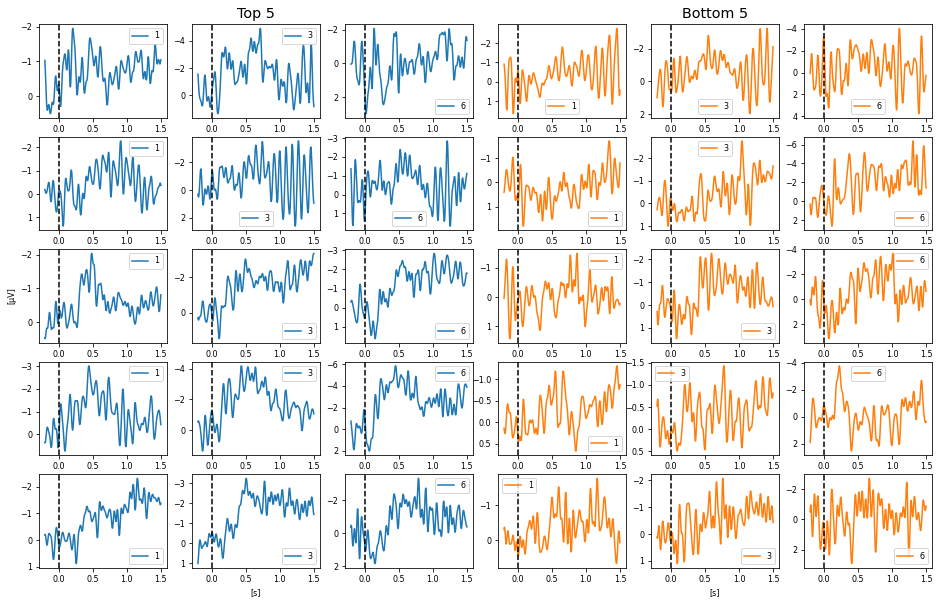

In [40]:
#plt.rcParams.update({'font.size': 8})

top5low5 = list(top5.values) + list(low5.values)
fig, axs = plt.subplots(5, 6, figsize=(16,10))
for i, participant in enumerate(top5low5):
    cur_cda = cda_dict_all[participant]

    if i >= 5:
        offset = 3
        pcolor = 'C1'
    else:
        offset = 0
        pcolor = 'C0'
        
    #for j, cond in enumerate(conds):
    j = 0
    cond = '1'
    cur_cda_stack = np.array([])
    for perf in ['acc_1']:
        for side in ['left', 'right']:
            side_dict = cur_cda[cond][side]
            if (perf in side_dict.keys() and len(side_dict[perf])):
                cur_cda_stack = np.vstack([cur_cda_stack, side_dict[perf]]) if len(cur_cda_stack) else side_dict[perf]
    
    axs[i%5,j+offset].plot((times), np.nanmean(cur_cda_stack, 0)*1e6, color=pcolor, label='{}'.format(cond))
    axs[i%5,j+offset].axvline(x=0, color='k', linestyle='--')
    #axs[0].set_ylim((-6,4))
    axs[i%5,j+offset].invert_yaxis()
    axs[i%5,j+offset].legend()
    
    j = 1
    cond = '3'
    cur_cda_stack = np.array([])
    for perf in ['acc_2','acc_3']:
        for side in ['left', 'right']:
            side_dict = cur_cda[cond][side]
            if (perf in side_dict.keys() and len(side_dict[perf])):
                cur_cda_stack = np.vstack([cur_cda_stack, side_dict[perf]]) if len(cur_cda_stack) else side_dict[perf]
   
    axs[i%5,j+offset].plot((times), np.nanmean(cur_cda_stack, 0)*1e6, color=pcolor, label='{}'.format(cond))
    axs[i%5,j+offset].axvline(x=0, color='k', linestyle='--')
    #axs[0].set_ylim((-6,4))
    axs[i%5,j+offset].invert_yaxis()
    axs[i%5,j+offset].legend()

    j = 2
    cond = '6'
    cur_cda_stack = np.array([])
    for perf in ['acc_3','acc_4','acc_5','acc_6']:
        for side in ['left', 'right']:
            side_dict = cur_cda[cond][side]
            if (perf in side_dict.keys() and len(side_dict[perf])):
                cur_cda_stack = np.vstack([cur_cda_stack, side_dict[perf]]) if len(cur_cda_stack) else side_dict[perf]

    axs[i%5,j+offset].plot((times), np.nanmean(cur_cda_stack, 0)*1e6, color=pcolor, label='{}'.format(cond))
    axs[i%5,j+offset].axvline(x=0, color='k', linestyle='--')
    #axs[0].set_ylim((-6,4))
    axs[i%5,j+offset].invert_yaxis()
    axs[i%5,j+offset].legend()

# Hardcode some labels
plt.rcParams.update({'font.size': 12})
axs[0,1].set_title('Top 5')
axs[0,4].set_title('Bottom 5')
plt.rcParams.update({'font.size': 8})
axs[4,1].set_xlabel('[s]')
axs[4,4].set_xlabel('[s]')
axs[2,0].set_ylabel('[μV]')

plt.savefig("./{}_top5low5.png".format(study_id), dpi=300, format='png')
plt.show()